# Performance metric selected from results of Model are Recall, F1-Score, AUC. 

* Recall is like of all positives, how many are predicted positives. If Recall will be better than our model will performance is good. Because if patients didn't done fraud but model shows that patients has done fraud then it is not good. For that reason, I am selecting Recall over Precision. If Recall will be better than our model performance will be better and we can rely on that as well. F1-Score is also coming better so we have selected that as because it is a harmonic mean of precision and recall. AUC is a area under curve to check whether our model didn't overfit or underfit.

* Best Model is Decision tree as per results shown in both approach. 

# 4. Modelling

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, precision_score,f1_score, roc_curve,auc 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from prettytable import PrettyTable

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/Case_Study_Preprocess_data.csv")
df.head(2)

,Unnamed: 0,Provider,PotentialFraud,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,Age_Of_Patients,Hospital_stay_Duration,Claim_Duration,Amount_left_reimburse,Diagnosis_Code_4019,Diagnosis_Code_25000,Diagnosis_Code_2724,Diagnosis_Code_V5869,Diagnosis_Code_4011,Diagnosis_Code_42731,Diagnosis_Code_V5861,Diagnosis_Code_2720,Diagnosis_Code_2449,Diagnosis_Code_4280,Procedure_Code_4019.0,Procedure_Code_9904.0,Procedure_Code_2724.0,Procedure_Code_8154.0,Procedure_Code_66.0,Procedure_Code_3893.0,Procedure_Code_3995.0,Procedure_Code_4516.0,Procedure_Code_3722.0,Procedure_Code_8151.0
0,0,25,0,5,01/05/1930,01/12/2009,1,1,1,1,660,1,1,1,1,2,2,1,1,2,2,2,20,1,443764,1,412312,0.0,517737,79.0,0.0,0,190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,25,0,2,01/03/1943,01/12/2009,1,1,0,1,440,1,2,2,2,2,2,1,1,1,2,1,700,3,443764,2,412312,0.0,517737,66.0,0.0,1,710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.drop(columns=["Unnamed: 0","DOB","DOD"],axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 50 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Provider                         558211 non-null  int64  
 1   PotentialFraud                   558211 non-null  int64  
 2   BeneID                           558211 non-null  int64  
 3   Gender                           558211 non-null  int64  
 4   Race                             558211 non-null  int64  
 5   RenalDiseaseIndicator            558211 non-null  int64  
 6   State                            558211 non-null  int64  
 7   County                           558211 non-null  int64  
 8   ChronicCond_Alzheimer            558211 non-null  int64  
 9   ChronicCond_Heartfailure         558211 non-null  int64  
 10  ChronicCond_KidneyDisease        558211 non-null  int64  
 11  ChronicCond_Cancer               558211 non-null  int64  
 12  Ch

In [ ]:
df["PotentialFraud"].value_counts()

0    345415
1    212796
Name: PotentialFraud, dtype: int64

In [ ]:
print("="*100)
print("The Percentage of NON Fraud after Pre-processing are: ",(df["PotentialFraud"].value_counts()[0]*100)/df["PotentialFraud"].count(),"%")
print("="*100)
print("The Percentage of Fraud after Pre-processing are: ",(df["PotentialFraud"].value_counts()[1]*100)/df["PotentialFraud"].count(),"%")
print("="*100)

The Percentage of NON Fraud after Pre-processing are:  61.878931085198964 %
The Percentage of Fraud after Pre-processing are:  38.121068914801036 %


# Considering Dataset as a Imbalanced dataset

# **Approach 1**

**Apply SMOTE After just Splitting into Train and Test**

In [ ]:
X = df.drop(["PotentialFraud"],axis=1)
y = df["PotentialFraud"]

In [ ]:
#Train Test Split
# train-test split as Train size= 60 and test size will be 20
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

print("The Shape of X_train : ",X_train.shape)
print("The Shape of X_test  : ",X_test.shape)
print("="*100)
print("The Shape of y_train : ",y_train.shape)
print("The Shape of y_train : ",y_test.shape)

The Shape of X_train :  (446568, 49)
The Shape of X_test  :  (111643, 49)
The Shape of y_train :  (446568,)
The Shape of y_train :  (111643,)


In [ ]:
# Normalizing data
scale_columns = ["Provider","BeneID","Race","State","County","InscClaimAmtReimbursed",
                 "AttendingPhysician","OperatingPhysician","OtherPhysician",
                 "ClmAdmitDiagnosisCode","DeductibleAmtPaid","DiagnosisGroupCode",
                 "Age_Of_Patients","Hospital_stay_Duration","Claim_Duration","Amount_left_reimburse"]

min_max_Scaling = MinMaxScaler()

In [ ]:
def scaler_columns(data_tr,data_te,column):
  
  min_max_Scaling.fit(data_tr[column].values.reshape(-1,1))

  scaler_train = min_max_Scaling.transform(data_tr[column].values.reshape(-1,1))
  
  scaler_test = min_max_Scaling.transform(data_te[column].values.reshape(-1,1))

  return scaler_train, scaler_test

In [ ]:
for i in scale_columns:
  X_train[i], X_test[i] = scaler_columns(X_train,X_test,i)

In [ ]:
# SMOTE 
oversample = SMOTE()
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)
counter_train = Counter(y_train_OS)

print("="*100)
print("The Percentage of NON Fraud after Pre-processing are: ",(counter_train[0]*100/(counter_train[0] + counter_train[1])),"%")
print("="*100)
print("The Percentage of Fraud after Pre-processing are: ",(counter_train[1]*100/(counter_train[0] + counter_train[1])),"%")
print("="*100)

The Percentage of NON Fraud after Pre-processing are:  50.0 %
The Percentage of Fraud after Pre-processing are:  50.0 %


# 4.1. Baseline Model

# 4.1.1. Logistics Regression

In [ ]:
# logistic regression 
params={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

logreg = LogisticRegression()
cross_val = RandomizedSearchCV(logreg, param_distributions=params, cv=5,n_jobs=-1, verbose=2)
cross_val.fit(X_train_OS, y_train_OS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_

In [ ]:
print("best parameters = ",cross_val.best_params_)

best parameters =  {'penalty': 'l2', 'C': 10.0}


The Recall score of Train:  0.7510313680645021
The Recall score of Test:  0.7284539473684211
The F1_Score of Train:  0.7857490369052238
The F1_Score of Test:  0.7335383887377264


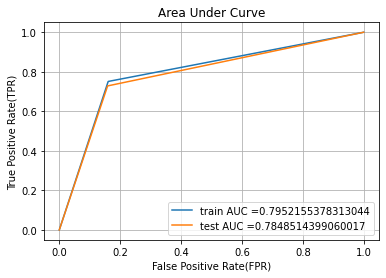

In [ ]:
logreg_best = cross_val.best_estimator_
logreg_best.fit(X_train_OS,y_train_OS)

y_train_pred = logreg_best.predict(X_train_OS)
y_test_pred = logreg_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_OS, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train_OS,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train_OS,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.630415510750349 for threshold 1
Train confusion matrix
[[231953  44379]
 [ 68798 207534]]
Test confusion matrix
[[58116 10967]
 [11557 31003]]


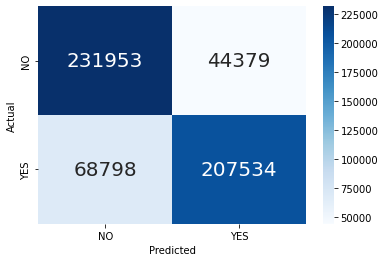

In [ ]:
confusion_matrix_train = confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

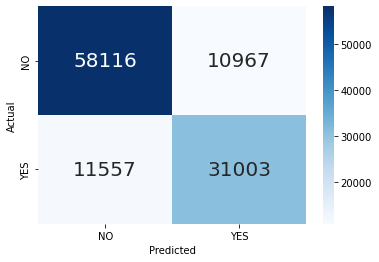

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

**feature_importance**

In [ ]:
# importance
importance_coef = logreg_best.coef_.tolist()[0]
cols = X_train.columns.tolist()
impor_coef_ = list(zip(cols, importance_coef))

# Each features is sort in descending order based on coefficient
top_features = pd.DataFrame(sorted(impor_coef_, key=lambda x: abs(x[1]),reverse=True),columns=["Feature_importance","impor_coef"])
top_features.head(20)

,Feature_importance,impor_coef
0,Provider,28.390276
1,AttendingPhysician,-3.506730
2,DiagnosisGroupCode,-1.955707
3,InscClaimAmtReimbursed,0.590806
4,Diagnosis_Code_2720,-0.426548
5,BeneID,0.409083
6,County,0.349824
7,DeductibleAmtPaid,0.289402
8,Diagnosis_Code_V5869,-0.284233
9,Diagnosis_Code_2724,-0.260579


# 4.1.2. SGDClassifier

In [ ]:
# SGDCLASSIFIER
sgd = SGDClassifier(class_weight='balanced',loss="hinge")

params ={'alpha':[0.0001,0.001,0.01,0.1,1,10,100],
          'penalty':["l1","l2"]}

cross_val = RandomizedSearchCV(sgd, param_distributions = params ,cv=5,n_jobs=-1,verbose=2)
cross_val.fit(X_train_OS,y_train_OS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight='balanced',
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=None, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributio

In [ ]:
print("best parameters = ",cross_val.best_params_)

best parameters =  {'penalty': 'l2', 'alpha': 0.0001}


The Recall score of Train:  0.7610881114022263
The Recall score of Test:  0.7391447368421052
The F1_Score of Train:  0.7850868842973664
The F1_Score of Test:  0.7303160802795157


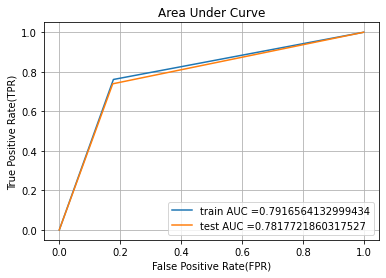

In [ ]:
sgd_best = cross_val.best_estimator_
sgd_best.fit(X_train_OS,y_train_OS)

y_train_pred = sgd_best.predict(X_train_OS)
y_test_pred = sgd_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_OS, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train_OS,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train_OS,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.625785455638021 for threshold 1
Train confusion matrix
[[227207  49125]
 [ 66019 210313]]
Test confusion matrix
[[56952 12131]
 [11102 31458]]


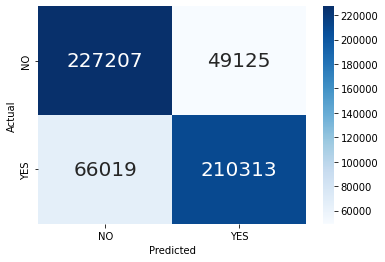

In [ ]:
confusion_matrix_train = confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

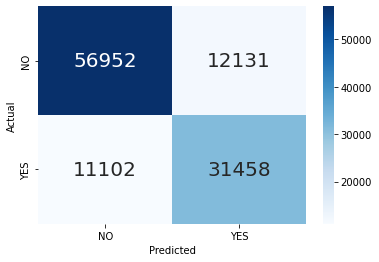

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

In [ ]:
# importance
importance_coef = sgd_best.coef_.tolist()[0]
cols = X_train.columns.tolist()
impor_coef_ = list(zip(cols, importance_coef))

# Each features is sort in descending order based on coefficient
top_features = pd.DataFrame(sorted(impor_coef_, key=lambda x: abs(x[1]),reverse=True),columns=["Feature_importance","impor_coef"])
top_features.head(20)

,Feature_importance,impor_coef
0,Provider,16.688771
1,DiagnosisGroupCode,-1.646572
2,AttendingPhysician,-1.644589
3,InscClaimAmtReimbursed,0.439885
4,DeductibleAmtPaid,0.348145
5,Procedure_Code_4019.0,-0.301492
6,Diagnosis_Code_2720,-0.212347
7,Amount_left_reimburse,-0.203738
8,BeneID,0.199793
9,County,0.184838


# 4.1.3. Decision Tree

In [ ]:
# Decision Tree
params={'max_depth':[5,10,30,50,70,100],
        'min_samples_split':[2,3,5,10],
        'criterion':['gini','entropy']}

dt = DecisionTreeClassifier(class_weight="balanced")

cross_val = RandomizedSearchCV(dt, param_distributions=params ,cv=5,n_jobs=-1,verbose=2)
cross_val.fit(X_train_OS,y_train_OS) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
    

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'min_samples_split': 10, 'max_depth': 70, 'criterion': 'entropy'}


The Recall score of Train:  0.9927080468422043
The Recall score of Test:  0.9761278195488722
The F1_Score of Train:  0.9942137662709509
The F1_Score of Test:  0.972984366766204


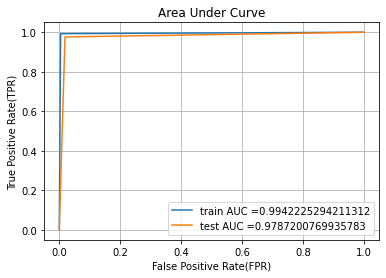

In [ ]:
dt_best = cross_val.best_estimator_
dt_best.fit(X_train_OS,y_train_OS)

y_train_pred = dt_best.predict(X_train_OS)
y_test_pred = dt_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_OS, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train_OS,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train_OS,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.98847614435107 for threshold 1
Train confusion matrix
[[275154   1178]
 [  2015 274317]]
Test confusion matrix
[[67792  1291]
 [ 1016 41544]]


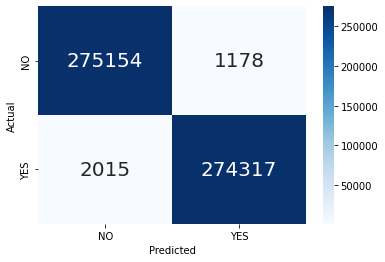

In [ ]:
confusion_matrix_train = confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

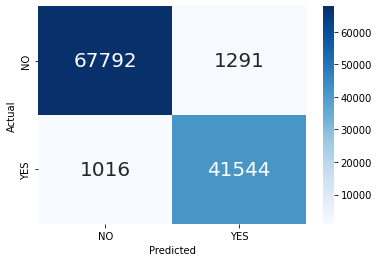

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

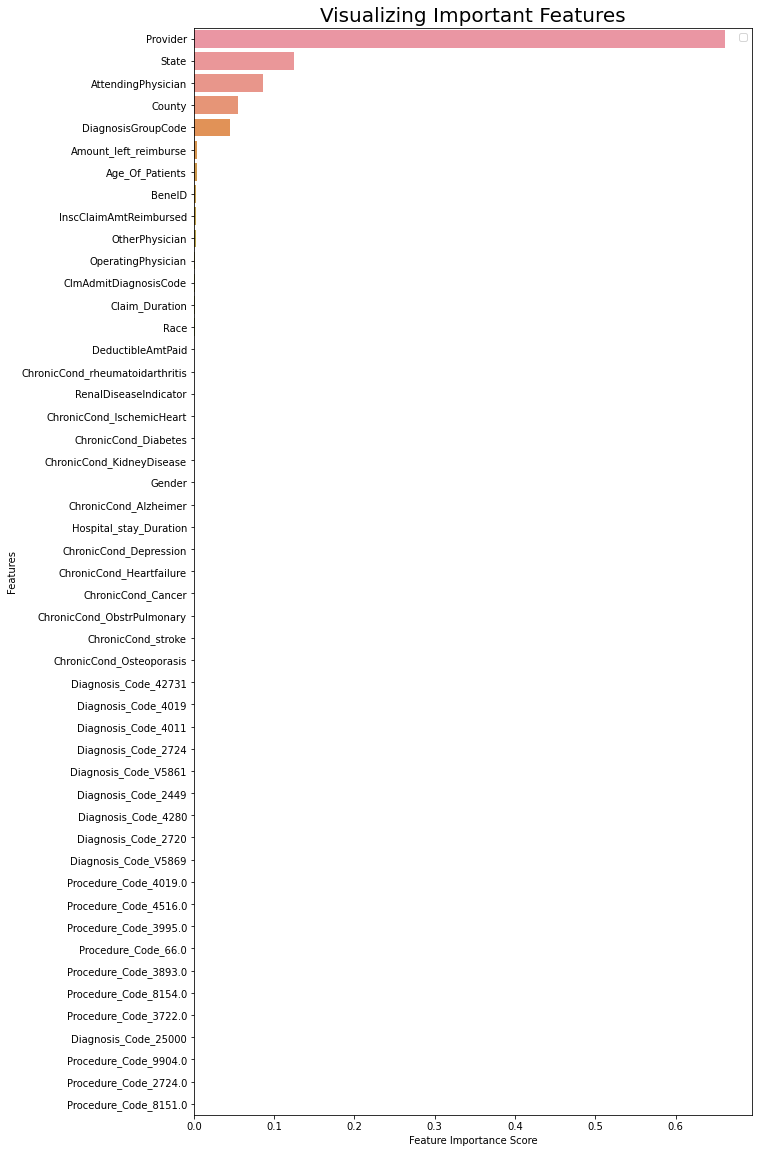

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(dt_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# 4.1.4. Xgboost

In [ ]:
# XGBClassifier

xgb = XGBClassifier()

 params = {'learning_rate':[0.01,0.03,0.05,0.1],
          'n_estimators':[5,10,15,20,50,70,100],
          'max_depth':[3,5,10]} 

cross_val = RandomizedSearchCV(xgb, param_distributions=params, cv=5,n_jobs=-1, verbose=10)
cross_val.fit(X_train_OS,y_train_OS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 39.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 39.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'n_estimators': 20, 'max_depth': 10, 'learning_rate': 0.05}


In [ ]:
X_test = X_test.to_numpy()

array([[0.02864425, 0.28571429, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.41170045, 0.42857143, 2.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0121374 , 0.14285714, 2.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01468625, 0.17857143, 2.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01177327, 0.46428571, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07136788, 0.14285714, 2.        , ..., 0.        , 0.        ,
        0.        ]])

The Recall score of Train:  0.8374093481753833
The Recall score of Test:  0.8352443609022556
The F1_Score of Train:  0.8970603627736405
The F1_Score of Test:  0.885589367347193


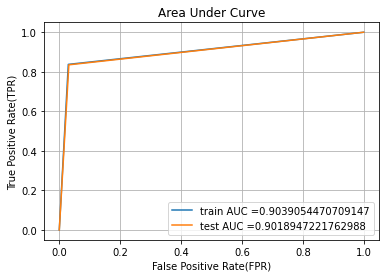

In [ ]:
xgb_best = cross_val.best_estimator_
xgb_best.fit(X_train_OS,y_train_OS)

y_train_pred = xgb_best.predict(X_train_OS)
y_test_pred = xgb_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_OS, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train_OS,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train_OS,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8126233260761458 for threshold 1
Train confusion matrix
[[268153   8179]
 [ 44929 231403]]
Test confusion matrix
[[66910  2173]
 [ 7012 35548]]


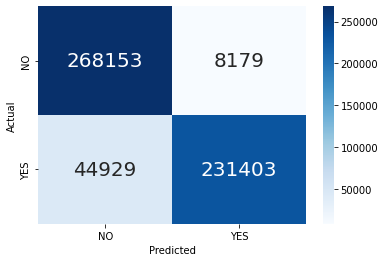

In [ ]:
confusion_matrix_train = confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

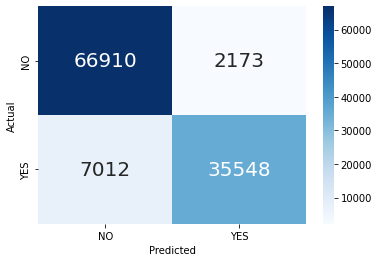

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

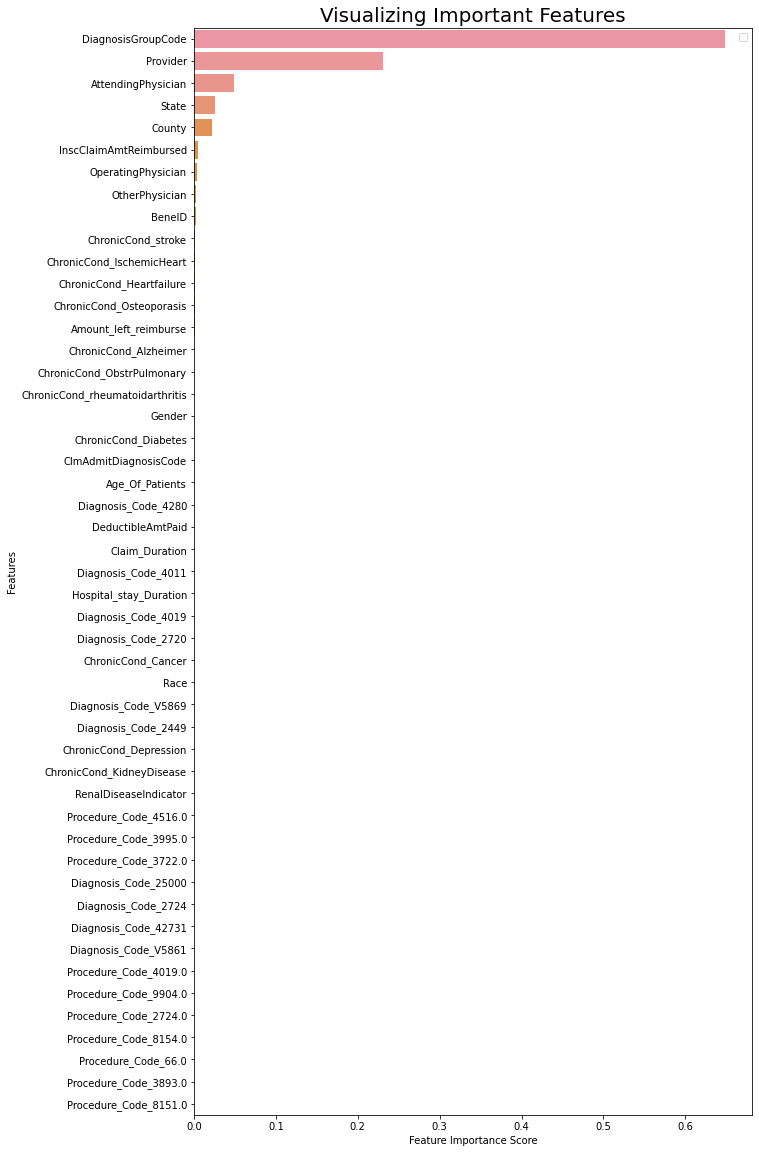

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# 4.1.5. Random Forest

In [ ]:
# Random Forest
params={'max_depth':[3,5,10],
        'min_samples_split':[2,3,5,10,20,50],
        'criterion':['gini','entropy']}

rf = RandomForestClassifier()

cross_val = RandomizedSearchCV(rf, param_distributions=params, cv=5, n_iter=10, n_jobs=-1, verbose=2)
cross_val.fit(X_train_OS, y_train_OS) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 39.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'min_samples_split': 20, 'max_depth': 10, 'criterion': 'gini'}


The Recall score of Train:  0.7101276725098794
The Recall score of Test:  0.6863016917293233
The F1_Score of Train:  0.8166746781365946
The F1_Score of Test:  0.7903723346682542


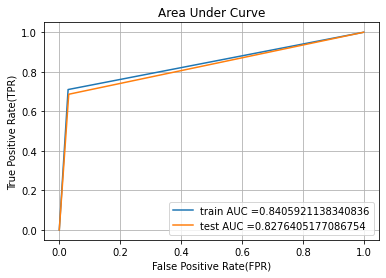

In [ ]:
rf_best = cross_val.best_estimator_
rf_best.fit(X_train_OS,y_train_OS)

y_train_pred = rf_best.predict(X_train_OS)
y_test_pred = rf_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_OS, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train_OS,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train_OS,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6895741313900162 for threshold 1
Train confusion matrix
[[268334   7998]
 [ 80101 196231]]
Test confusion matrix
[[66940  2143]
 [13351 29209]]


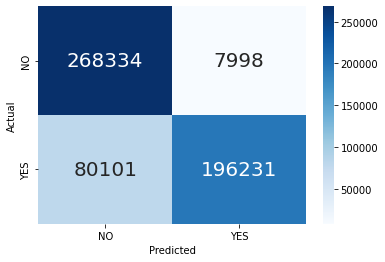

In [ ]:
confusion_matrix_train = confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

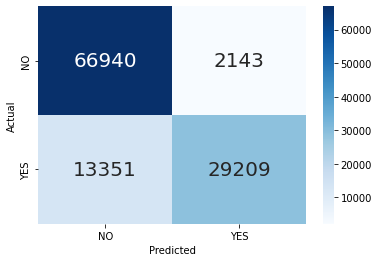

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

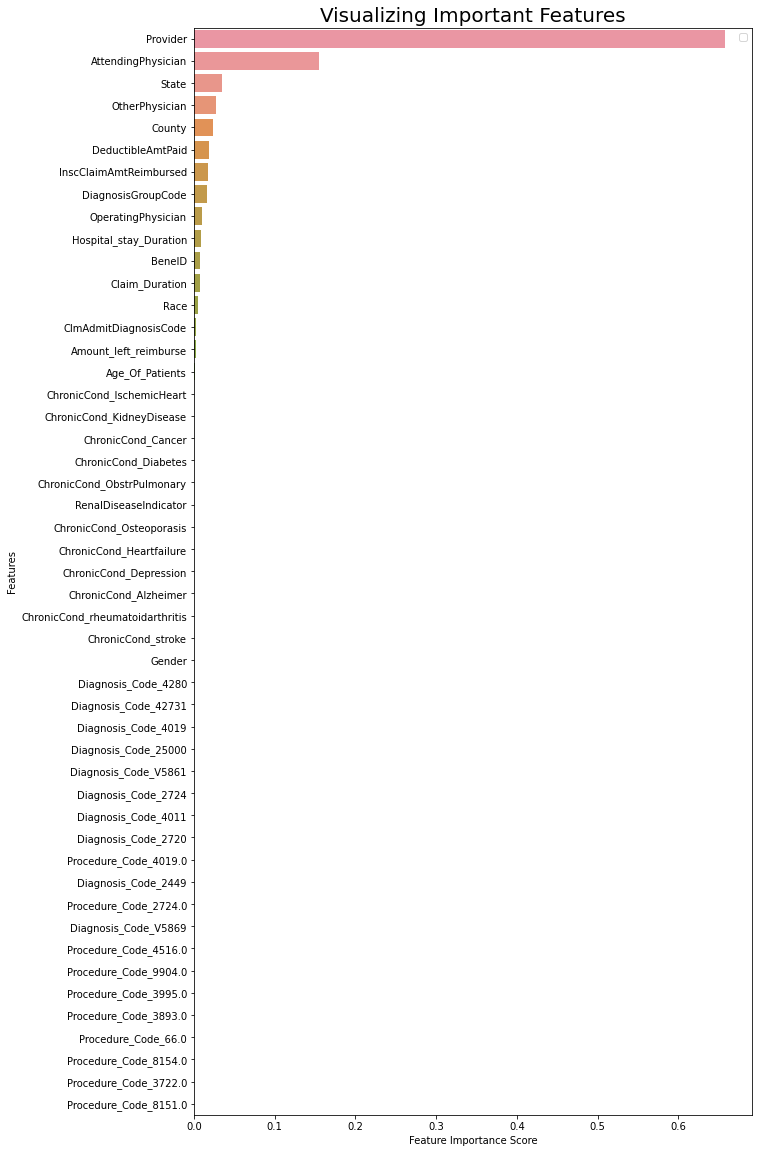

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# 4.1.6. LGBM

In [ ]:
# LGBMClassifier
lgbm = LGBMClassifier(class_weight="balanced")

params = {'learning_rate':[0.01,0.03,0.05,0.1,1],
         'n_estimators':[10,20,50,70,100],
         'max_depth':[3,5,10]} 

cross_val = RandomizedSearchCV(lgbm, param_distributions=params, cv=5,n_jobs=-1, verbose=10)
cross_val.fit(X_train_OS,y_train_OS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,
                                            subsample_f

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'n_estimators': 10, 'max_depth': 10, 'learning_rate': 0.1}


The Recall score of Train:  0.7751219547500833
The Recall score of Test:  0.7690084586466165
The F1_Score of Train:  0.8499609128535204
The F1_Score of Test:  0.8326083085298532


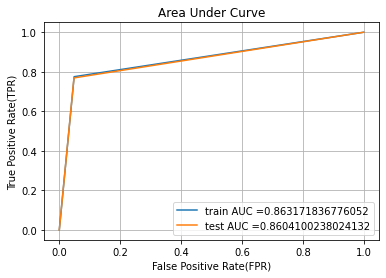

In [ ]:
lgbm_best = cross_val.best_estimator_
lgbm_best.fit(X_train_OS,y_train_OS)

y_train_pred = lgbm_best.predict(X_train_OS)
y_test_pred = lgbm_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_OS, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train_OS,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train_OS,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.7373128380785564 for threshold 1
Train confusion matrix
[[262853  13479]
 [ 62141 214191]]
Test confusion matrix
[[65754  3329]
 [ 9831 32729]]


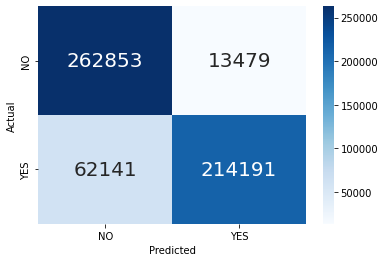

In [ ]:
confusion_matrix_train = confusion_matrix(y_train_OS, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

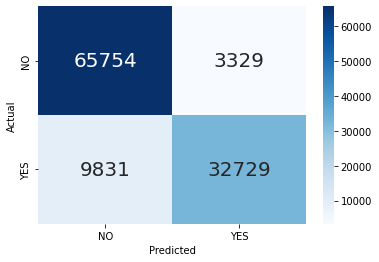

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

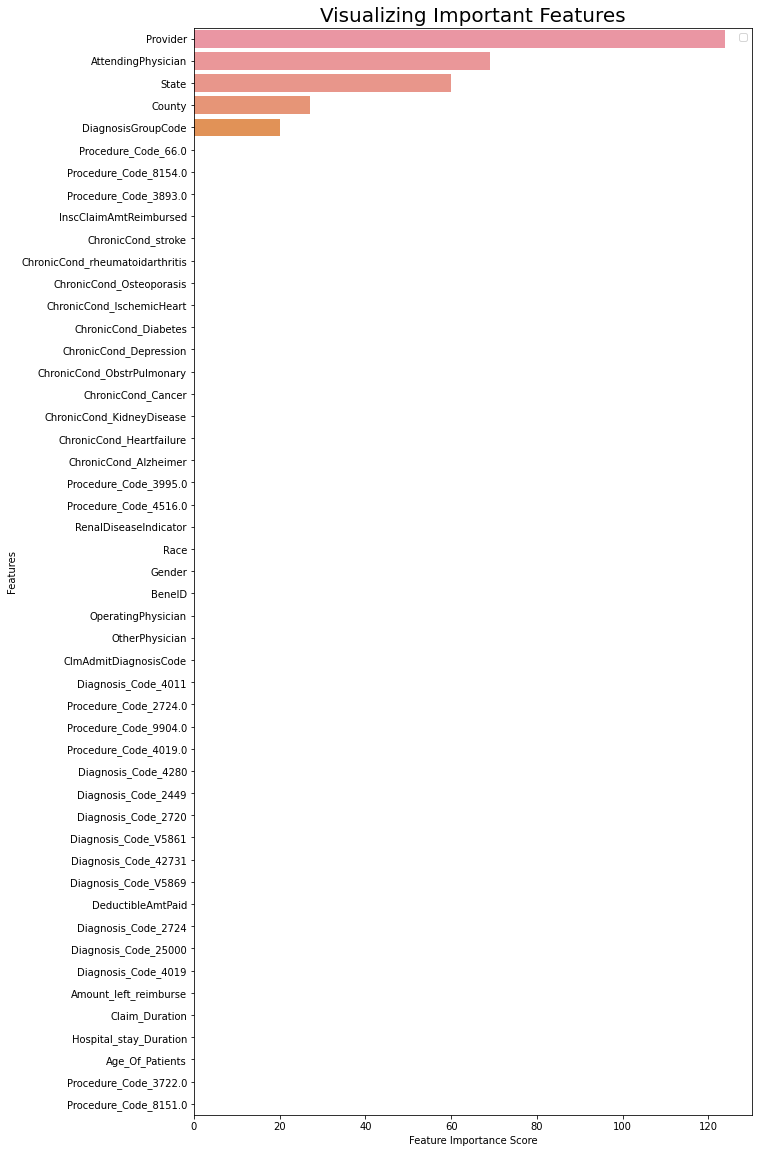

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(lgbm_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# **Approach 2**

**Applying SMOTE Before Spliting into Train and Test**

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/Case_Study_Preprocess_data.csv")
df2.drop(columns=["Unnamed: 0","DOB","DOD"],axis=1,inplace=True)


In [ ]:
X = df2.drop(["PotentialFraud"],axis=1)
y = df2["PotentialFraud"]

In [ ]:
# SMOTE with Oversample
oversample = SMOTE()
X_OS, y_OS = oversample.fit_resample(X, y)
counter_train = Counter(y_OS)

print("="*100)
print("The Percentage of NON Fraud after Pre-processing are: ",(counter_train[0]*100/(counter_train[0] + counter_train[1])),"%")
print("="*100)
print("The Percentage of Fraud after Pre-processing are: ",(counter_train[1]*100/(counter_train[0] + counter_train[1])),"%")
print("="*100)

The Percentage of NON Fraud after Pre-processing are:  50.0 %
The Percentage of Fraud after Pre-processing are:  50.0 %


In [ ]:
#Train Test Split
# train-test split as Train size= 80 and test size will be 20
X_train,X_test,y_train,y_test = train_test_split(X_OS,y_OS, test_size=0.2,random_state=0)

print("The Shape of X_train : ",X_train.shape)
print("The Shape of X_test  : ",X_test.shape)
print("="*100)
print("The Shape of y_train : ",y_train.shape)
print("The Shape of y_train : ",y_test.shape)

The Shape of X_train :  (552664, 49)
The Shape of X_test  :  (138166, 49)
The Shape of y_train :  (552664,)
The Shape of y_train :  (138166,)


# 5.1. Baseline Model

# 5.1.1. Logistic Regression

In [ ]:
# logistic regression
params={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

logreg = LogisticRegression()
cross_val = GridSearchCV(logreg, param_grid=params, cv=5,n_jobs=-1, verbose=2)
cross_val.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  5.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
print("best parameters = ",cross_val.best_params_)

best parameters =  {'C': 10.0, 'penalty': 'l2'}


The Recall score of Train:  0.7296226333159632
The Recall score of Test:  0.7323499182095862
The F1_Score of Train:  0.7686934906144142
The F1_Score of Test:  0.7700503828180892


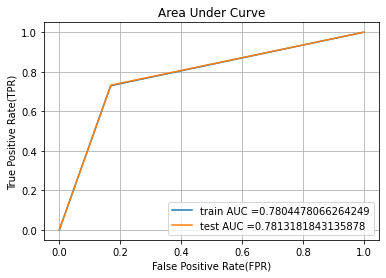

In [ ]:
logreg_best = cross_val.best_estimator_
logreg_best.fit(X_train,y_train)

y_train_pred = logreg_best.predict(X_train)
y_test_pred = logreg_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.606515580625959 for threshold 1
Train confusion matrix
[[229704  46624]
 [ 74715 201621]]
Test confusion matrix
[[57362 11725]
 [18489 50590]]


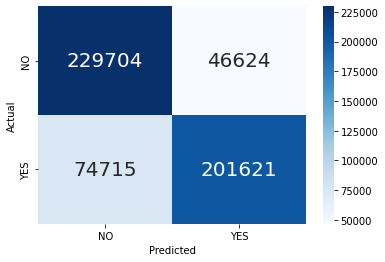

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

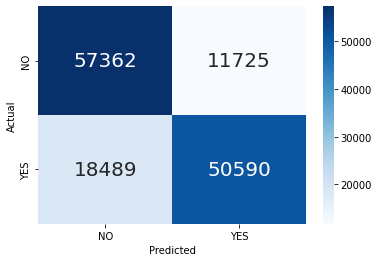

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

In [ ]:
# importance
importance_coef = logreg_best.coef_.tolist()[0]
cols = X_train.tolist()
impor_coef_ = list(zip(cols, importance_coef))

# Each features is sort in descending order based on coefficient
top_features = pd.DataFrame(sorted(impor_coef_, key=lambda x: abs(x[1]),reverse=True),columns=["Feature_importance","impor_coef"])
top_features.head(20)

,Feature_importance,impor_coef
0,"[8240.0, 5.0, 2.0, 1.0, 1.0, 5.0, 200.0, 1.0, ...",2.911917e-03
1,"[89.0, 5.0, 2.0, 1.0, 0.0, 45.0, 756.0, 1.0, 1...",3.434091e-04
2,"[178.34394327431127, 3.346587004559368, 1.0, 2...",-2.069888e-04
3,"[2067.0, 2.735209863957368, 1.264790136042632,...",1.826425e-05
4,"[840.0, 11.0, 1.0, 1.0, 0.0, 30.0, 80.0, 1.0, ...",-8.108419e-06
5,"[330.0, 12.0, 2.0, 1.0, 0.0, 5.0, 660.0, 1.0, ...",4.475153e-06
6,"[21.0, 3.0, 2.0, 1.0, 0.0, 44.0, 60.0, 2.0, 2....",-3.751137e-06
7,"[397.0, 4.0, 2.0, 1.0, 0.0, 34.0, 800.0, 1.0, ...",3.158089e-06
8,"[672.0, 4.0, 1.0, 1.0, 0.0, 36.0, 110.0, 2.0, ...",-1.198746e-06
9,"[257.0, 6.0, 2.0, 1.0, 0.0, 30.0, 50.0, 1.0, 2...",-9.145821e-07


# 5.1.2. SGDClassifier

In [ ]:
# SGD CLASSIFIER
alpha = [0.0001,0.001,0.01,0.1,1,10]
penalty = ["l1","l2"]

lr = SGDClassifier(class_weight='balanced',loss="hinge")

params ={'alpha':alpha, 
         'penalty':penalty}

cross_val = RandomizedSearchCV(lr, param_distributions=params,cv=5,n_jobs=-1,verbose=10)
cross_val.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 57.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 73.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 90.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 97.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight='balanced',
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=None, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributio

In [ ]:
print("best parameters = ",cross_val.best_params_)

best parameters =  {'penalty': 'l1', 'alpha': 0.0001}


The Recall score of Train:  0.7934000636905796
The Recall score of Test:  0.7942645377032094
The F1_Score of Train:  0.7835803558983413
The F1_Score of Test:  0.7836967312046049


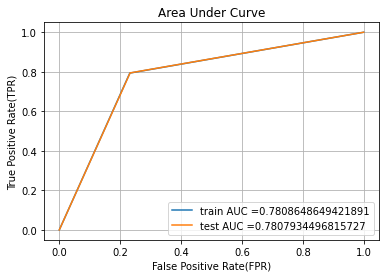

In [ ]:
sgd_best = cross_val.best_estimator_
sgd_best.fit(X_train,y_train)

y_train_pred = sgd_best.predict(X_train)
y_test_pred = sgd_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6095928060935216 for threshold 1
Train confusion matrix
[[212311  64017]
 [ 57091 219245]]
Test confusion matrix
[[53012 16075]
 [14212 54867]]


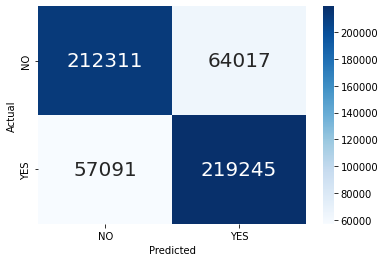

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

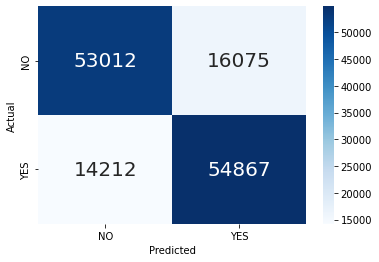

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

In [ ]:
# importance
importance_coef = sgd_best.coef_.tolist()[0]
cols = X_train.tolist()
impor_coef_ = list(zip(cols, importance_coef))

# Each features is sort in descending order based on coefficient
top_features = pd.DataFrame(sorted(impor_coef_, key=lambda x: abs(x[1]),reverse=True),columns=["Feature_importance","impor_coef"])
top_features.head(20)

,Feature_importance,impor_coef
0,"[8240.0, 5.0, 2.0, 1.0, 1.0, 5.0, 200.0, 1.0, ...",1.198420e+07
1,"[1037.0, 4.205428338313712, 2.0, 1.59819055389...",9.966341e+05
2,"[89.0, 5.0, 2.0, 1.0, 0.0, 45.0, 756.0, 1.0, 1...",2.811777e+05
3,"[864.0, 7.0, 2.0, 1.0, 0.0, 37.0, 130.0, 2.0, ...",-1.811697e+05
4,"[330.0, 12.0, 2.0, 1.0, 0.0, 5.0, 660.0, 1.0, ...",-2.856640e+04
5,"[672.0, 4.0, 1.0, 1.0, 0.0, 36.0, 110.0, 2.0, ...",-1.624052e+04
6,"[2313.0, 8.0, 2.0, 1.0, 0.0, 45.0, 130.0, 1.0,...",-1.409453e+04
7,"[21.0, 3.0, 2.0, 1.0, 0.0, 44.0, 60.0, 2.0, 2....",-1.099183e+04
8,"[257.0, 6.0, 2.0, 1.0, 0.0, 30.0, 50.0, 1.0, 2...",8.842697e+03
9,"[129.0, 9.0, 2.0, 1.0, 0.0, 33.0, 280.0, 2.0, ...",5.903770e+03


# 5.1.3. Decision Tree

In [ ]:
# Decision Tree

params={'max_depth':[5,10,30,50,70,100],
        'min_samples_split':[2,3,5,10],
        'criterion':['gini','entropy']}

dt = DecisionTreeClassifier(class_weight="balanced")

cross_val = RandomizedSearchCV(dt, param_distributions=params ,cv=5,n_jobs=-1,verbose=2)
cross_val.fit(X_train,y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
    

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'min_samples_split': 10, 'max_depth': 70, 'criterion': 'entropy'}


The Recall score of Train:  0.9902690926987435
The Recall score of Test:  0.9613486008772565
The F1_Score of Train:  0.9924995012966287
The F1_Score of Test:  0.9672857038817275


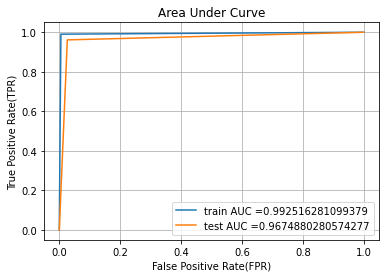

In [ ]:
dt_best = cross_val.best_estimator_
dt_best.fit(X_train,y_train)

y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.9850835183916336 for threshold 1
Train confusion matrix
[[274881   1447]
 [  2689 273647]]
Test confusion matrix
[[67265  1822]
 [ 2670 66409]]


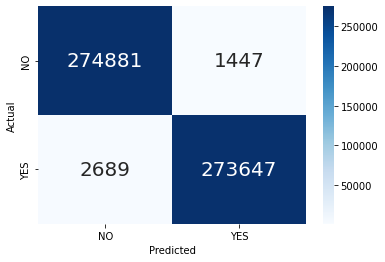

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

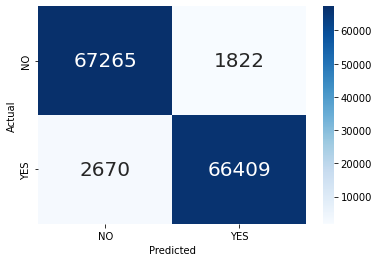

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

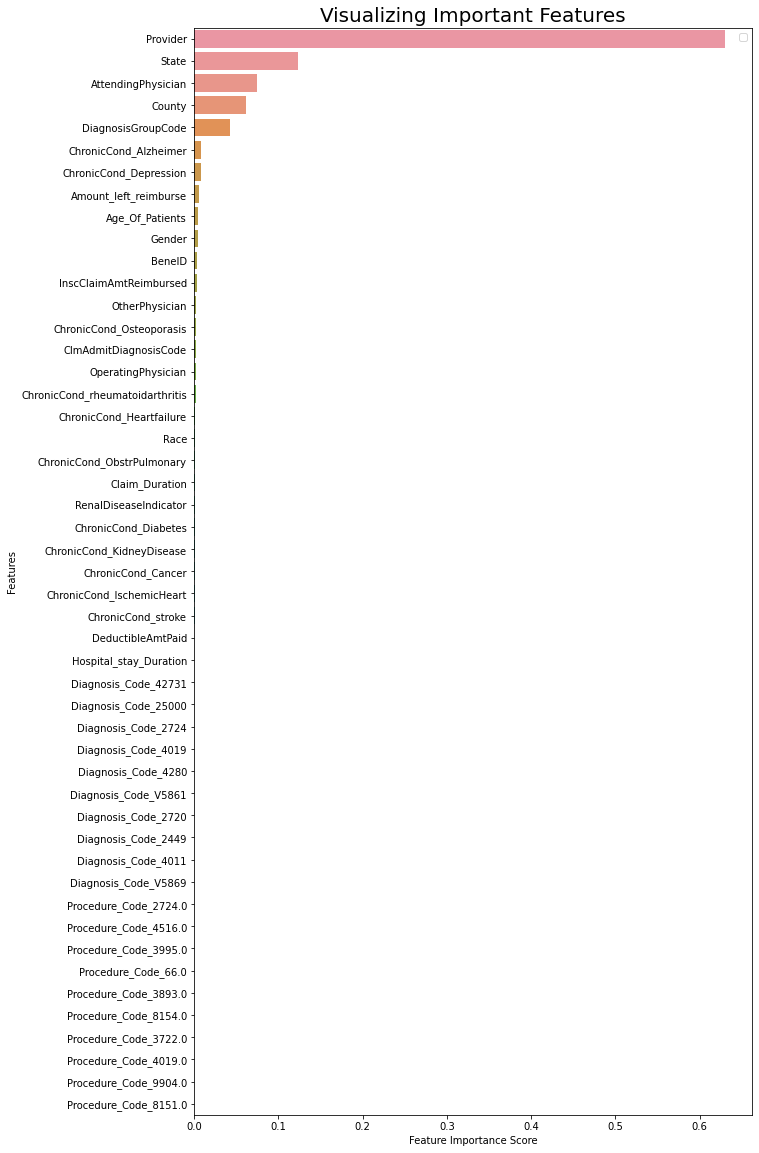

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(dt_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# 5.1.4. LGBM

In [ ]:
# LGBMClassifier
lgbm = LGBMClassifier(class_weight="balanced")

params = {'learning_rate':[0.01,0.03,0.05,0.1,1,10],
         'n_estimators':[10,20,30,50,70,100],
         'max_depth':[3,5,10]} 

cross_val = RandomizedSearchCV(lgbm, param_distributions=params, cv=5,n_jobs=-1, verbose=10)
cross_val.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,
                                            subsample_f

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 1}


The Recall score of Train:  0.9484431995831162
The Recall score of Test:  0.9448891848463353
The F1_Score of Train:  0.9641881588604371
The F1_Score of Test:  0.961543844142452


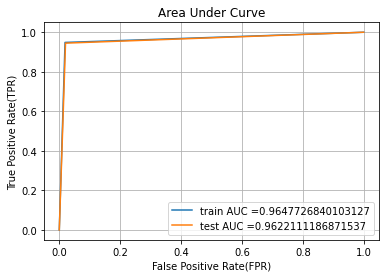

In [ ]:
lgbm_best = cross_val.best_estimator_
lgbm_best.fit(X_train,y_train)

y_train_pred = lgbm_best.predict(X_train)
y_test_pred = lgbm_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.9305196797508045 for threshold 1
Train confusion matrix
[[271106   5222]
 [ 14247 262089]]
Test confusion matrix
[[67673  1414]
 [ 3807 65272]]


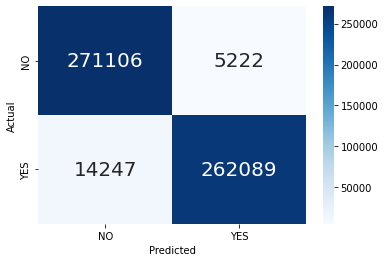

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

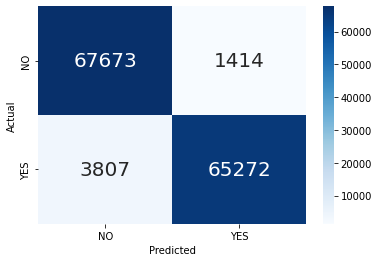

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

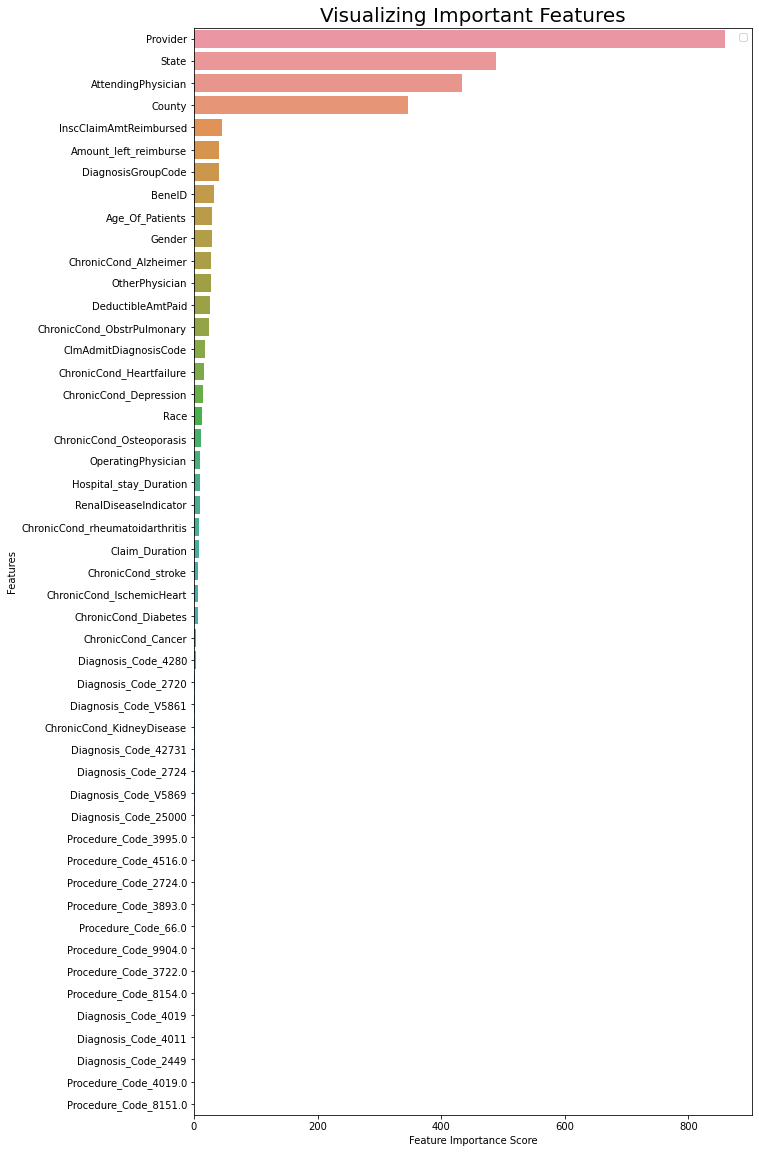

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(lgbm_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# Considering Dataset as a Balanced dataset

# Approach 3

In [ ]:
df3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/Case_Study_Preprocess_data.csv")
df3.drop(columns=["Unnamed: 0","DOB","DOD"],axis=1,inplace=True)

In [ ]:
X = df3.drop(["PotentialFraud"],axis=1)
y = df3["PotentialFraud"]

NameError: ignored

In [ ]:
X.to_numpy()
y.to_numpy()

In [ ]:
# Train Test Split
# train-test split as Train size= 80 and test size will be 20
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=0)

print("The Shape of X_train : ",X_train.shape)
print("The Shape of X_test  : ",X_test.shape)
print("="*100)
print("The Shape of y_train : ",y_train.shape)
print("The Shape of y_train : ",y_test.shape)

The Shape of X_train :  (446568, 49)
The Shape of X_test  :  (111643, 49)
The Shape of y_train :  (446568,)
The Shape of y_train :  (111643,)


In [ ]:
# Normalizing data
scale_columns = ["Provider","BeneID","Race","State","County","InscClaimAmtReimbursed",
                 "AttendingPhysician","OperatingPhysician","OtherPhysician",
                 "ClmAdmitDiagnosisCode","DeductibleAmtPaid","DiagnosisGroupCode",
                 "Age_Of_Patients","Hospital_stay_Duration","Claim_Duration","Amount_left_reimburse"]

min_max_Scaling = MinMaxScaler()

In [ ]:
def scaler_columns(data_tr,data_te,column):
  
  min_max_Scaling.fit(data_tr[column].values.reshape(-1,1))

  scaler_train = min_max_Scaling.transform(data_tr[column].values.reshape(-1,1))
  
  scaler_test = min_max_Scaling.transform(data_te[column].values.reshape(-1,1))

  return scaler_train, scaler_test

In [ ]:
for i in scale_columns:
  X_train[i], X_test[i] = scaler_columns(X_train,X_test,i)

# 6.1. Baseline Model

# 6.1.1. Logistic Regression

In [ ]:
# logistic regression
params={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

logreg = LogisticRegression()
cross_val = RandomizedSearchCV(logreg, param_distributions=params, cv=5,n_jobs=-1, verbose=2)
cross_val.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_

In [ ]:
print("best parameters = ",cross_val.best_params_)

best parameters =  {'penalty': 'l2', 'C': 0.01}


The Recall score of Train:  0.6511045828437133
The Recall score of Test:  0.6494976054089586
The F1_Score of Train:  0.7448797832940116
The F1_Score of Test:  0.7443099273607748


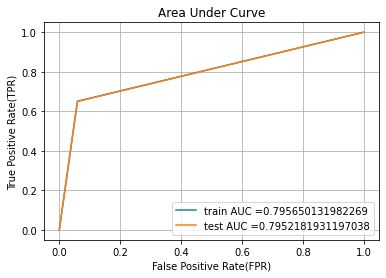

In [ ]:
logreg_best = cross_val.best_estimator_
logreg_best.fit(X_train,y_train)

y_train_pred = logreg_best.predict(X_train)
y_test_pred = logreg_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6121657167476353 for threshold 1
Train confusion matrix
[[259840  16528]
 [ 59382 110818]]
Test confusion matrix
[[64969  4078]
 [14930 27666]]


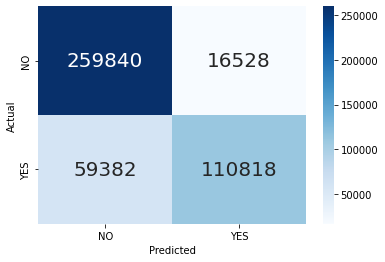

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

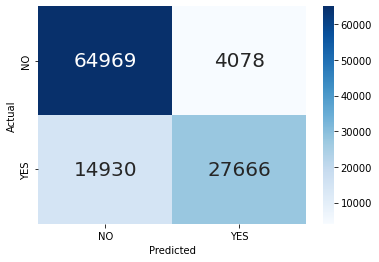

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

In [ ]:
# importance
importance_coef = logreg_best.coef_.tolist()[0]
cols = X_train.columns.tolist()
impor_coef_ = list(zip(cols, importance_coef))

# Each features is sort in descending order based on coefficient
top_features = pd.DataFrame(sorted(impor_coef_, key=lambda x: abs(x[1]),reverse=True),columns=["Feature_importance","impor_coef"])
top_features.head(20)

,Feature_importance,impor_coef
0,Provider,16.773452
1,DiagnosisGroupCode,-1.293162
2,DeductibleAmtPaid,0.476717
3,BeneID,0.339766
4,County,0.330709
5,InscClaimAmtReimbursed,0.307609
6,AttendingPhysician,0.115439
7,Race,0.082238
8,Amount_left_reimburse,-0.072403
9,Procedure_Code_4019.0,-0.059912


# 6.1.2. SGDClassifier

In [ ]:
# SGDCLASSIFIER
alpha = [0.0001,0.001,0.01,0.1,1,10]
p = ["l1","l2"]

sgd = SGDClassifier(class_weight='balanced',loss="hinge")

params ={'alpha':alpha,
          'penalty':p}

cross_val = RandomizedSearchCV(sgd, param_distributions = params ,cv=5,n_jobs=-1,verbose=2)
cross_val.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight='balanced',
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=None, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributio

In [ ]:
print("best parameters = ",cross_val.best_params_)

best parameters =  {'penalty': 'l2', 'alpha': 0.001}


The Recall score of Train:  0.6931609870740305
The Recall score of Test:  0.6901821767302094
The F1_Score of Train:  0.7365765945756956
The F1_Score of Test:  0.7349566260843478


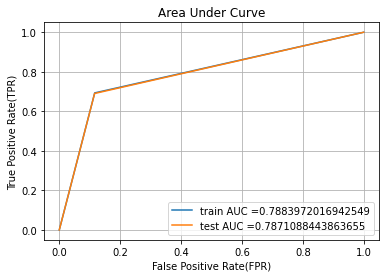

In [ ]:
sgd_best = cross_val.best_estimator_
sgd_best.fit(X_train,y_train)

y_train_pred = sgd_best.predict(X_train)
y_test_pred = sgd_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6125002110641422 for threshold 1
Train confusion matrix
[[244208  32160]
 [ 52224 117976]]
Test confusion matrix
[[61040  8007]
 [13197 29399]]


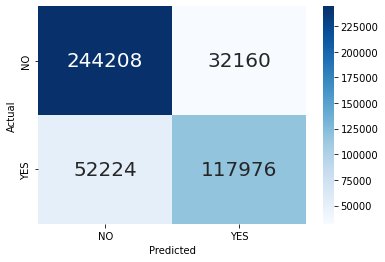

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

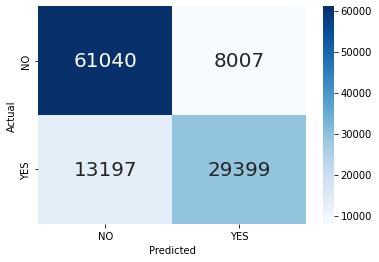

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

In [ ]:
# importance
importance_coef = logreg_best.coef_.tolist()[0]
cols = X_train.columns.tolist()
impor_coef_ = list(zip(cols, importance_coef))

# Each features is sort in descending order based on coefficient
top_features = pd.DataFrame(sorted(impor_coef_, key=lambda x: abs(x[1]),reverse=True),columns=["Feature_importance","impor_coef"])
top_features.head(20)

,Feature_importance,impor_coef
0,Provider,16.773452
1,DiagnosisGroupCode,-1.293162
2,DeductibleAmtPaid,0.476717
3,BeneID,0.339766
4,County,0.330709
5,InscClaimAmtReimbursed,0.307609
6,AttendingPhysician,0.115439
7,Race,0.082238
8,Amount_left_reimburse,-0.072403
9,Procedure_Code_4019.0,-0.059912


# 6.1.3. Decision Tree

In [ ]:
# Decision Tree
params={'max_depth':[5,10,30,50,70,100],
        'min_samples_split':[2,3,5,10],
        'criterion':['gini','entropy']}

dt = DecisionTreeClassifier(class_weight="balanced")

cross_val = RandomizedSearchCV(dt, param_distributions=params ,cv=5,n_jobs=-1,verbose=2)
cross_val.fit(X_train,y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
    

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'min_samples_split': 5, 'max_depth': 50, 'criterion': 'entropy'}


The Recall score of Train:  0.9989424206815511
The Recall score of Test:  0.9803267912480045
The F1_Score of Train:  0.9980716002782531
The F1_Score of Test:  0.9789363871860092


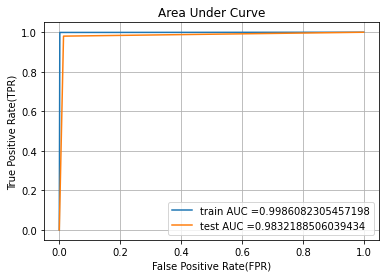

In [ ]:
dt_best = cross_val.best_estimator_
dt_best.fit(X_train,y_train)

y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.9972182864306064 for threshold 1
Train confusion matrix
[[275891    477]
 [   180 170020]]
Test confusion matrix
[[68088   959]
 [  838 41758]]


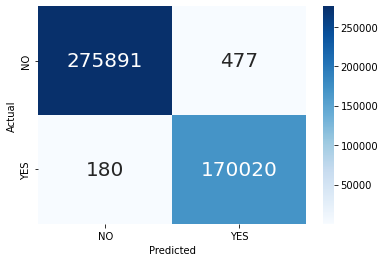

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

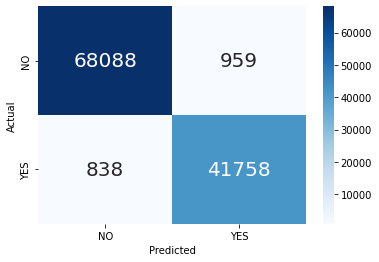

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

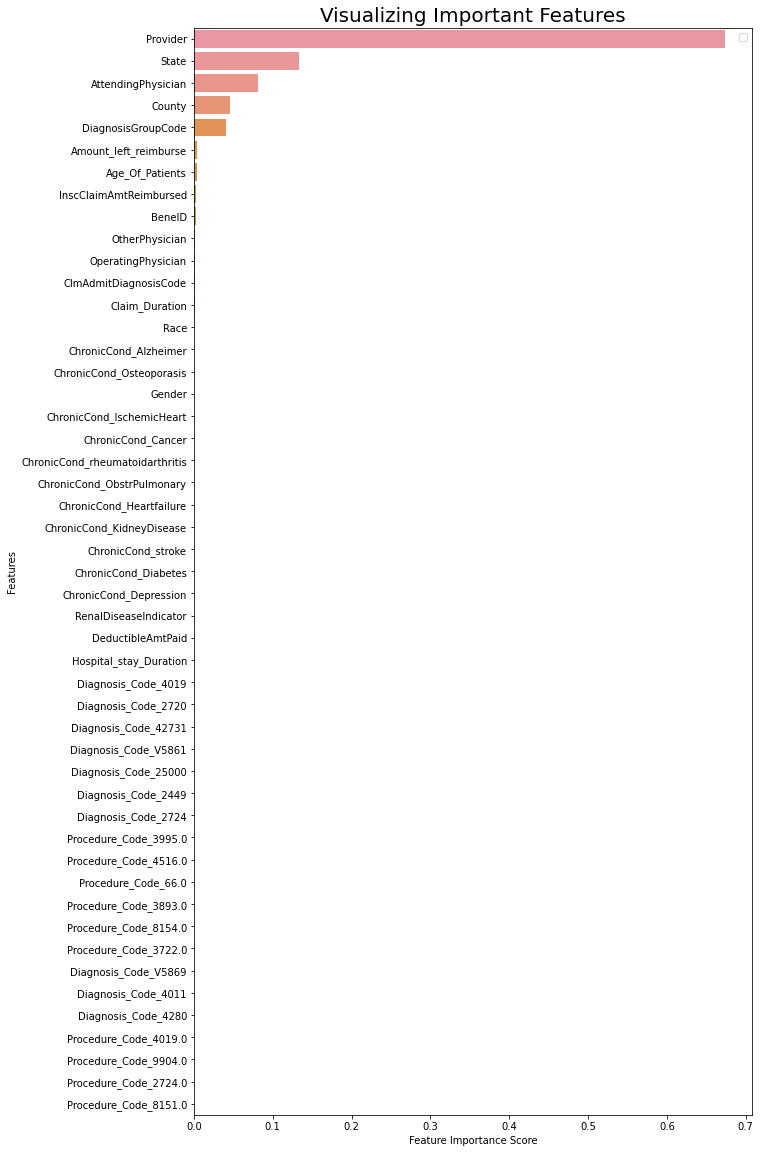

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(dt_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# 6.1.4. Xgboost

In [ ]:
# XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

xgb = XGBClassifier()

params = {'learning_rate':[0.01,0.03,0.05,0.1],
          'n_estimators':[5,10,15,20,50,70,100],
          'max_depth':[3,5,10]} 

cross_val = RandomizedSearchCV(xgb, param_distributions=params, cv=5,n_jobs=-1, verbose=10)
cross_val.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 33.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.1}


The Recall score of Train:  0.8868625146886017
The Recall score of Test:  0.8833458540708048
The F1_Score of Train:  0.9376772386031502
The F1_Score of Test:  0.9350529938743306


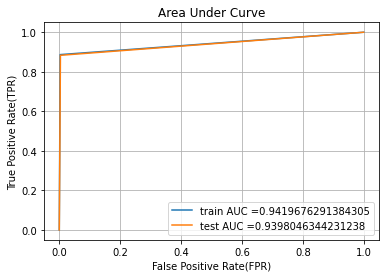

In [ ]:
xgb_best = cross_val.best_estimator_
xgb_best.fit(X_train,y_train)

y_train_pred = xgb_best.predict(X_train)
y_test_pred = xgb_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8842664407061468 for threshold 1
Train confusion matrix
[[275559    809]
 [ 19256 150944]]
Test confusion matrix
[[68789   258]
 [ 4969 37627]]


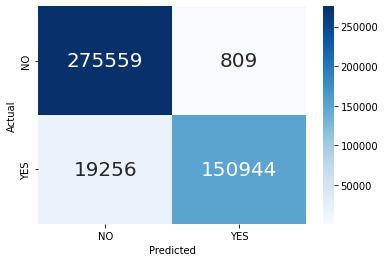

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

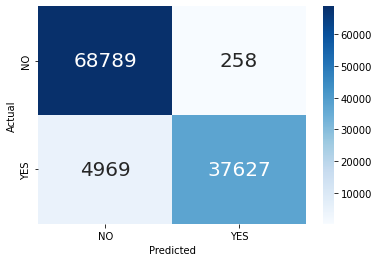

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

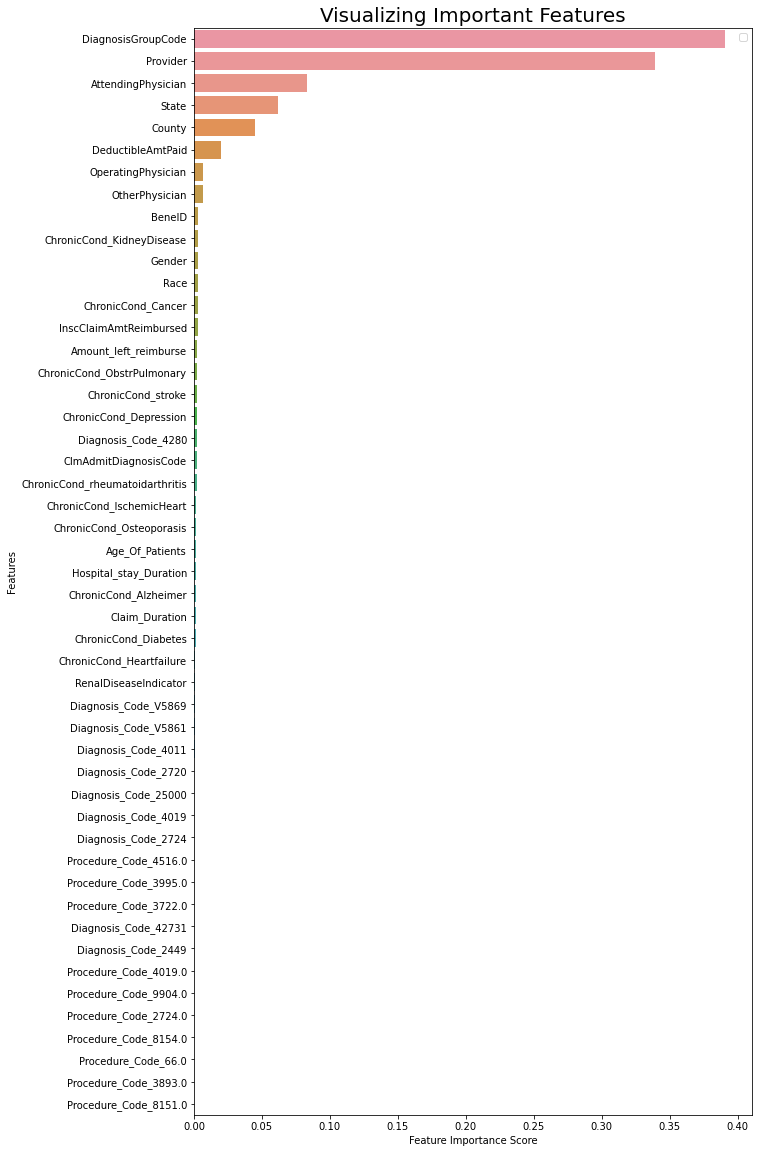

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# 6.1.5. Random Forest

In [ ]:
# Random Forest
params={'max_depth':[3,5,10],
        'min_samples_split':[2,3,5,10,20,50],
        'criterion':['gini','entropy']}

rf = RandomForestClassifier()

cross_val = RandomizedSearchCV(rf, param_distributions=params, cv=5, n_iter=10, n_jobs=-1, verbose=2)
cross_val.fit(X_train, y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 20.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'min_samples_split': 10, 'max_depth': 10, 'criterion': 'gini'}


The Recall score of Train:  0.6358813160987073
The Recall score of Test:  0.6305521645224904
The F1_Score of Train:  0.7687313769431018
The F1_Score of Test:  0.7640817023213473


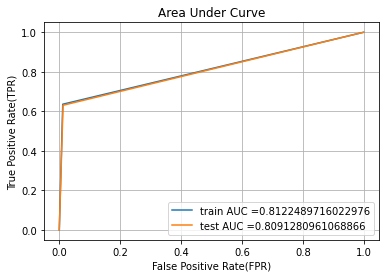

In [ ]:
rf_best = cross_val.best_estimator_
rf_best.fit(X_train,y_train)

y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6286428419611569 for threshold 1
Train confusion matrix
[[273222   3146]
 [ 61973 108227]]
Test confusion matrix
[[68198   849]
 [15737 26859]]


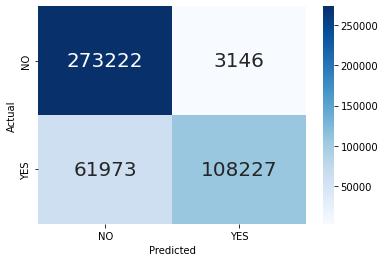

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

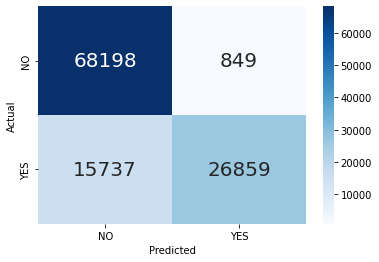

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

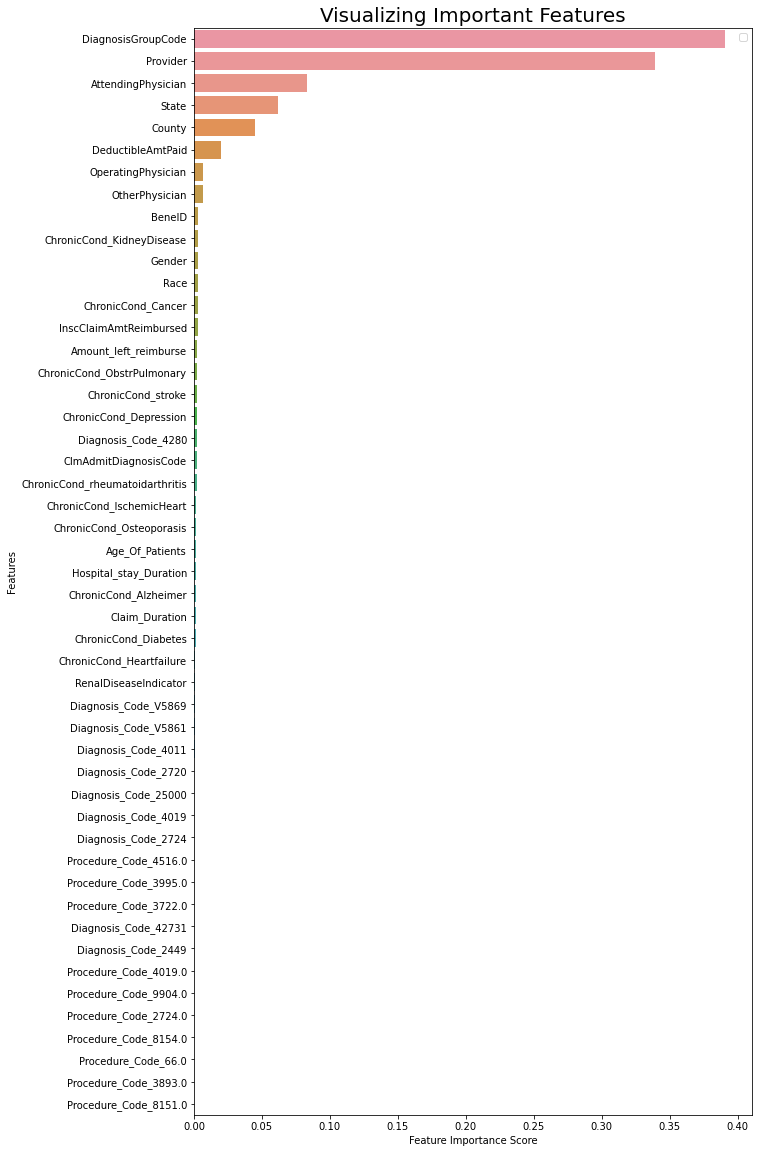

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# 6.1.6. LGBM

In [ ]:
# LGBMClassifier
lgbm = LGBMClassifier(class_weight="balanced")

params = {'learning_rate':[0.01,0.03,0.05,0.1,1,10],
         'n_estimators':[10,20,30,50,70,100],
         'max_depth':[3,5,10]} 

cross_val = RandomizedSearchCV(lgbm, param_distributions=params, cv=5,n_jobs=-1, verbose=10)
cross_val.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,
                                            subsample_f

In [ ]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 1}


The Recall score of Train:  0.8937837837837838
The Recall score of Test:  0.8925251197295521
The F1_Score of Train:  0.9098205741626795
The F1_Score of Test:  0.9078058215334656


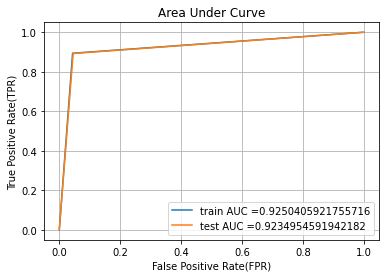

In [ ]:
lgbm_best = cross_val.best_estimator_
lgbm_best.fit(X_train,y_train)

y_train_pred = lgbm_best.predict(X_train)
y_test_pred = lgbm_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8547231091016912 for threshold 1
Train confusion matrix
[[264290  12078]
 [ 18078 152122]]
Test confusion matrix
[[65903  3144]
 [ 4578 38018]]


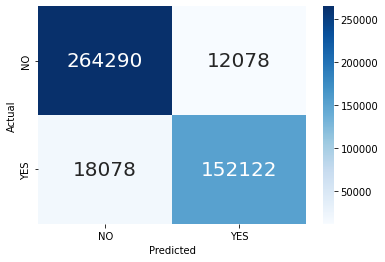

In [ ]:
confusion_matrix_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, columns=np.unique(y_true), index = np.unique(y_true))
confusion_matrix_train.index.name = 'Actual'
confusion_matrix_train.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_train, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

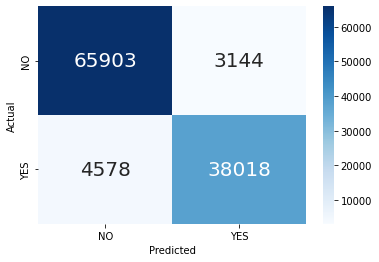

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
y_true = ['NO','YES']
y_pred = ['NO','YES']
df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
df_confusion_matrix_test.index.name = 'Actual'
df_confusion_matrix_test.columns.name = 'Predicted'
sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')

No handles with labels found to put in legend.


<Figure size 720x648 with 0 Axes>

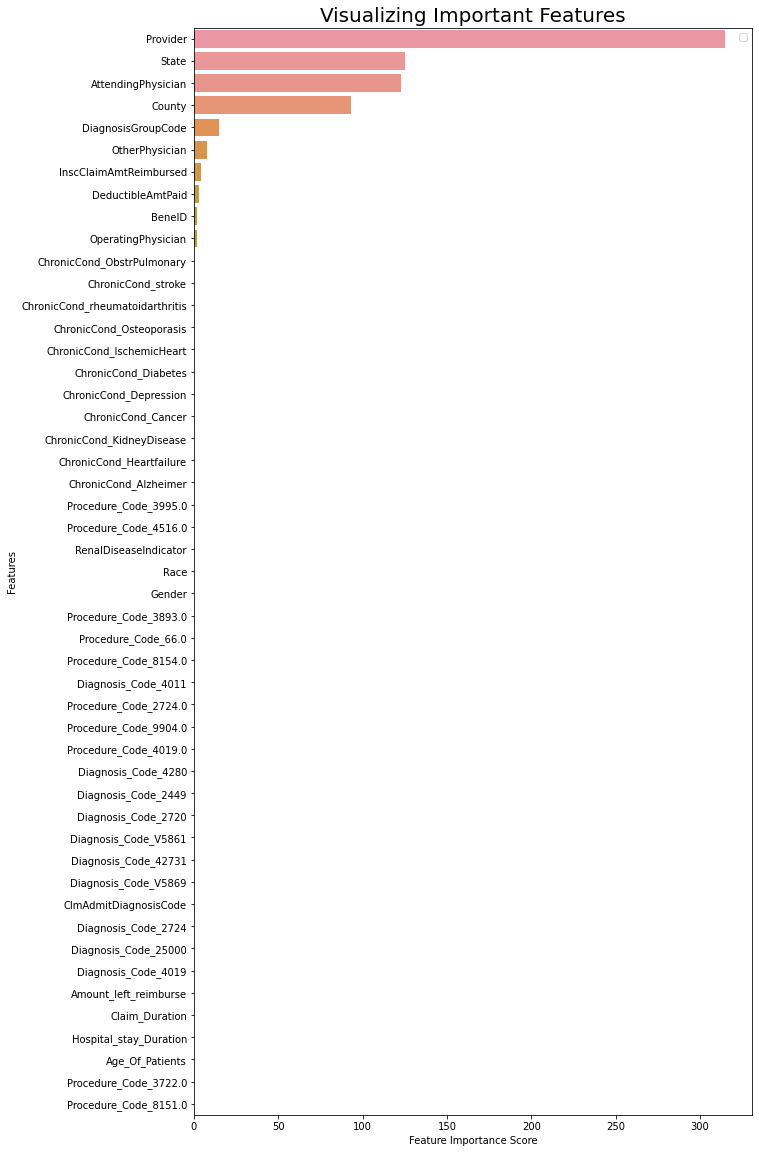

In [ ]:
plt.figure(figsize=(10,9))
feature_importance = pd.Series(lgbm_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# creating a bar plot
plt.figure(figsize=(10,20))
sns.barplot(x=feature_importance, y=feature_importance.index)

# adding label to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=20)
plt.legend()
plt.show()

# 7. Results for Approach 1, Approach 2 and Approach 3

In [ ]:
print("="*100)
print("CONSIDER DATASET AS IMBALANCED DATA")
print("Approach 1 Results")
print("Apply SMOTE After just Splitting into Train and Test")

x = PrettyTable()
x.field_names = ["Model","Train_Recall","Test_Recall",
                 "Train_F1_Score","Test_F1_Score",
                 "Train_AUC","Test_AUC"]

x.add_row(["LogisticRegression",0.75,0.72,0.78,0.73,0.79,0.78])
x.add_row(["SGDClassifier",0.76,0.74,0.78,0.73,0.79,0.78])
x.add_row(["DecisionTreeClassifier", 0.99,0.97,0.99,0.97,0.99,0.97])
x.add_row(["XGBClassifier",0.83,0.83,0.89,0.88,0.90,0.90])
x.add_row(["RandomForestClassifier",0.71,0.69,0.81,0.79,0.84,0.83])
x.add_row(["LGBM",0.77,0.77,0.85,0.83,0.86,0.86])
print(x)
print("="*100)

print("Approach 2 Results")
print("Applying SMOTE Before Spliting into Train and Test")
x = PrettyTable()
x.field_names = ["Model","Train_Recall","Test_Recall",
                 "Train_F1_Score","Test_F1_Score",
                 "Train_AUC","Test_AUC"]

x.add_row(["LogisticRegression",0.73,0.73,0.76,0.77,0.78,0.78])
x.add_row(["SGDClassifier",0.79,0.79,0.78,0.78,0.78,0.78])
x.add_row(["DecisionTreeClassifier",0.99,0.96,0.99,0.97,0.99,0.97])
x.add_row(["LGBM",0.95,0.94,0.96,0.96,0.96,0.96])
print(x)
print("="*100)

print("Approach 3 Results")
print("Consider DATASET AS BALANCED DATA")
x = PrettyTable()
x.field_names = ["Model","Train_Recall","Test_Recall",
                 "Train_F1_Score","Test_F1_Score",
                 "Train_AUC","Test_AUC"]

x.add_row(["LogisticRegression",0.65,0.65,0.74,0.74,0.79,0.79])
x.add_row(["SGDClassifier",0.69,0.69,0.73,0.73,0.79,0.79])
x.add_row(["DecisionTreeClassifier", 0.99,0.98,0.99,0.98,0.99,0.98])
x.add_row(["XGBClassifier",0.89,0.88,0.94,0.93,0.94,0.94])
x.add_row(["RandomForestClassifier",0.63,0.63,0.76,0.76,0.81,0.81])
x.add_row(["LGBM",0.89,0.89,0.90,0.90,0.92,0.92])
print(x)
print("="*100)

Consider Dataset As an IMBALANCED DATA
Approach 1 Results
Apply SMOTE After just Splitting into Train and Test
+------------------------+--------------+-------------+----------------+---------------+-----------+----------+
|         Model          | Train_Recall | Test_Recall | Train_F1_Score | Test_F1_Score | Train_AUC | Test_AUC |
+------------------------+--------------+-------------+----------------+---------------+-----------+----------+
|   LogisticRegression   |     0.75     |     0.72    |      0.78      |      0.73     |    0.79   |   0.78   |
|     SGDClassifier      |     0.76     |     0.74    |      0.78      |      0.73     |    0.79   |   0.78   |
| DecisionTreeClassifier |     0.99     |     0.97    |      0.99      |      0.97     |    0.99   |   0.97   |
|     XGBClassifier      |     0.83     |     0.83    |      0.89      |      0.88     |    0.9    |   0.9    |
| RandomForestClassifier |     0.71     |     0.69    |      0.81      |      0.79     |    0.84   |   0.

# 8. Custom Models

In [ ]:
X = df.drop(["PotentialFraud"],axis=1)
y = df["PotentialFraud"]

In [ ]:
# Train Test Split
# train-test split as Train size= 80 and test size will be 20
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=0)

print("The Shape of X_train : ",X_train.shape)
print("The Shape of X_test  : ",X_test.shape)
print("="*100)
print("The Shape of y_train : ",y_train.shape)
print("The Shape of y_train : ",y_test.shape)

The Shape of X_train :  (446568, 49)
The Shape of X_test  :  (111643, 49)
The Shape of y_train :  (446568,)
The Shape of y_train :  (111643,)


In [ ]:
# train split as D1 and D2 as 50:50
d1_train,d2_train,d1_test,d2_test = train_test_split(X_train,y_train, test_size=0.5,random_state=0)

print("The Shape of d2_train : ",d1_train.shape)
print("The Shape of d2_train  : ",d2_train.shape)
print("="*100)
print("The Shape of d1_test : ",d1_test.shape)
print("The Shape of d2_test : ",d2_test.shape)

The Shape of d2_train :  (223284, 49)
The Shape of d2_train  :  (223284, 49)
The Shape of d1_test :  (223284,)
The Shape of d2_test :  (223284,)


In [ ]:
def gen_samples(data, target):

  row_sample = random.sample(range(0, data.shape[0]), int((60/100)*(data.shape[0])))
  row_replace = random.sample(row_sample, int((40/100)*(data.shape[0])))
  row_sam_rep = row_sample + row_replace
  column_sample = random.sample(range(0, data.shape[1]), random.randrange(3,49))

  a = data.iloc[row_sam_rep]
  a = a.iloc[:,column_sample]
  b = target.iloc[row_sam_rep]

  return a,b,row_sam_rep,column_sample

In [ ]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# 8.1. Meta_Models for k_samples

In [ ]:
def custom_model(k_sample,m):
  
  input = []
  target = []
  row = []
  column = []

  for i in range(k_sample):
    a,b,row_sam_rep,column_sample = gen_samples(d1_train, d1_test)
    input.append(a)
    target.append(b)
    row.append(row_sam_rep)
    column.append(column_sample)
  
  baseline_model = []
  for i in range(k_sample):
    X_train = input[i]
    y_train = target[i]
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=50, min_samples_split=5) # creating k base models
    dt.fit(X_train, y_train)
    baseline_model.append(dt)

  # passing D2 to these k models
  predict_for_D2 = []
  for i in range(k_sample):
    pred_D2 = baseline_model[i].predict(d2_train.iloc[:,column[i]])
    predict_for_D2.append(pred_D2)
  predict_for_D2 = np.array(predict_for_D2).transpose()

  # predicting X_test data using k models
  predict_for_X_test=[]
  for i in range(k_sample):
    pred_test = baseline_model[i].predict(X_test.iloc[:,column[i]])
    predict_for_X_test.append(pred_test)
  predict_for_X_test = np.array(predict_for_X_test).transpose()

  if m==1:
    # Meta_Model as Logistic Regression
    params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    
    logreg = LogisticRegression()
    cross_val = RandomizedSearchCV(logreg, param_distributions=params, cv=5, n_iter=10, n_jobs=-1, verbose=2)
    cross_val.fit(predict_for_D2,d2_test)
    print("The Best parameters are: ",cross_val.best_params_)

  if m==2:
    # Meta_Model as SGDCLASSIFIER
    params = {'alpha':[0.0001,0.001,0.01,0.1,1,10],
          'penalty':["l1","l2"]}

    sgd = SGDClassifier(class_weight='balanced', loss="hinge")
    cross_val = RandomizedSearchCV(sgd, param_distributions = params ,cv=5,n_jobs=-1,verbose=2)
    cross_val.fit(predict_for_D2,d2_test)
    print("The Best parameters are: ",cross_val.best_params_)

  if m==3:
    # Meta_Model as DecisionTree
    params = {'max_depth':[5,10,30,50,70,100],
            'min_samples_split':[2,3,5,10],
            'criterion':['gini','entropy']}

    dt = DecisionTreeClassifier(class_weight="balanced")
    cross_val = RandomizedSearchCV(dt, param_distributions=params ,cv=5, n_iter=10, n_jobs=-1,verbose=2)
    cross_val.fit(predict_for_D2,d2_test)
    print("The Best parameters are: ",cross_val.best_params_) 

  if m==4:
    # Meta_Model as XGBoost
    xgb = XGBClassifier()
    params = {'learning_rate':[0.01,0.03,0.05,0.1],
              'n_estimators':[5,10,15,20,50,70,100],
              'max_depth':[3,5,10]} 

    cross_val = RandomizedSearchCV(xgb, param_distributions=params, cv=5,n_iter=10, n_jobs=-1, verbose=10)
    cross_val.fit(predict_for_D2,d2_test) 
    print("The Best parameters are: ",cross_val.best_params_)
    
  if m==5:
    # Meta_Model as RandomForest
    params={'max_depth':[3,5,10],
            'min_samples_split':[2,3,5,10,20,50],
            'criterion':['gini','entropy']}

    rf = RandomForestClassifier()
    cross_val = RandomizedSearchCV(rf, param_distributions=params, cv=5, n_iter=10, n_jobs=-1, verbose=2)
    cross_val.fit(predict_for_D2,d2_test) 
    print("The Best parameters are: ",cross_val.best_params_)
  
  if m==6:
    # Meta_Model as LGBM
    lgbm = LGBMClassifier(class_weight="balanced")

    params = {'learning_rate':[0.01,0.03,0.05,0.1,1,10],
              'n_estimators':[10,20,30,50,70,100],
              'max_depth':[3,5,10]} 
    cross_val = RandomizedSearchCV(lgbm, param_distributions=params, cv=5,n_jobs=-1, verbose=10)
    cross_val.fit(predict_for_D2,d2_test)
    print("The Best parameters are: ",cross_val.best_params_)
  
  meta_model = cross_val.best_estimator_
  y_test_pred = meta_model.predict(predict_for_X_test)
    
  test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

  #recall_score
  recall_score_test = recall_score(y_test,y_test_pred)

  #f1_score
  f1_score_test = f1_score(y_test,y_test_pred)

  print("="*50)
  print("The Recall score of Test: ",recall_score_test)
  print("="*50)
  print("The F1_Score of Test: ",f1_score_test)
  print("="*50)
  
  plt.figure(1)
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")
  plt.title("Area Under Curve")
  plt.grid()
  plt.show()
  
  # confusion matrix
  plt.figure(2)
  best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
  print("Test confusion matrix") 
  confusion_matrix_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
  y_true = ['NO','YES']
  y_pred = ['NO','YES']
  df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
  df_confusion_matrix_test.index.name = 'Actual'
  df_confusion_matrix_test.columns.name = 'Predicted'
  sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')
  plt.show()

  return meta_model ,baseline_model, column

# 8.1.1. Custom Models with K Samples as LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.9s finished


The Best parameters are:  {'penalty': 'l2', 'C': 100.0}
The Recall score of Test:  0.9791294957272983
The F1_Score of Test:  0.9844799301301799


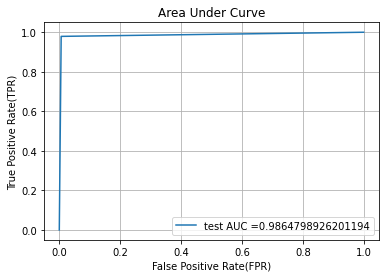

the maximum value of tpr*(1-fpr) 0.9730885502093204 for threshold 1
Test confusion matrix


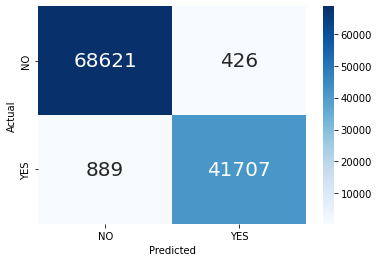

In [ ]:
lr, meta_model_lr, column_lr = custom_model(49,1)  

In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_lr.pkl", 'wb') as file:
    pickle.dump(lr, file)

# 8.1.2. Custom Models with K Samples as SGD

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.4s finished


The Best parameters are:  {'penalty': 'l1', 'alpha': 0.001}
The Recall score of Test:  0.9777443891445207
The F1_Score of Test:  0.9821483315646741


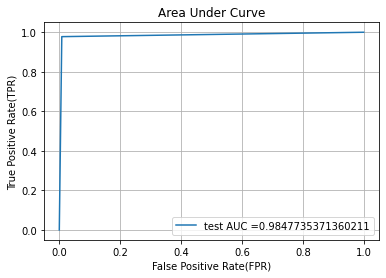

the maximum value of tpr*(1-fpr) 0.9697295105219041 for threshold 1
Test confusion matrix


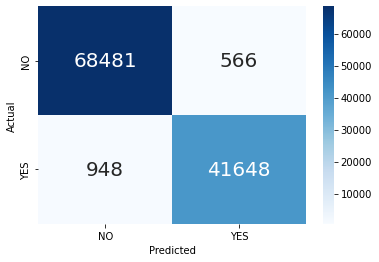

In [ ]:
sgd, meta_model_sgd,column_sgd = custom_model(49,2)

In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_sgd.pkl", 'wb') as file:
    pickle.dump(sgd, file)

# 8.1.3. Custom Models with K Samples as Decision Tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


The Best parameters are:  {'min_samples_split': 5, 'max_depth': 10, 'criterion': 'entropy'}
The Recall score of Test:  0.9775096253169312
The F1_Score of Test:  0.980652150873185


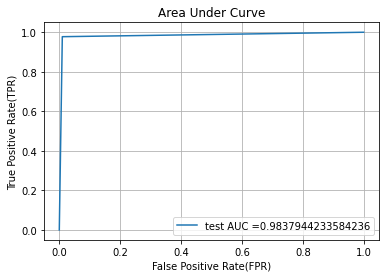

the maximum value of tpr*(1-fpr) 0.9678119687447109 for threshold 1
Test confusion matrix


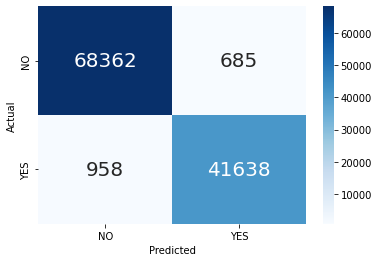

In [ ]:
dt, meta_model_dt,column_dt = custom_model(49,3)

In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_dt.pkl", 'wb') as file:
    pickle.dump(dt, file)

# 8.1.4. Custom Models with K Samples as Xgboost

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.6min finished


The Best parameters are:  {'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.1}
The Recall score of Test:  0.9740116442858484
The F1_Score of Test:  0.9804449800905085


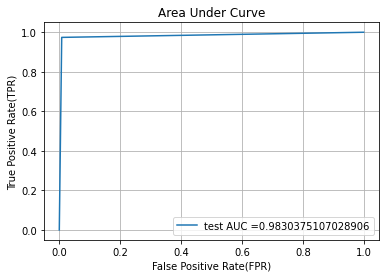

the maximum value of tpr*(1-fpr) 0.9662812811843574 for threshold 1
Test confusion matrix


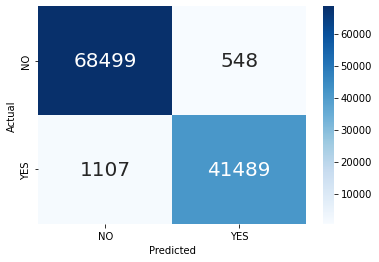

In [ ]:
xgb, meta_model_xgb,column_xgb = custom_model(49,4)

In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_xgb.pkl", 'wb') as file:
    pickle.dump(xgb, file)

# 8.1.5. Custom Models with K Samples as Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.2min finished


The Best parameters are:  {'min_samples_split': 3, 'max_depth': 10, 'criterion': 'gini'}
The Recall score of Test:  0.9730725889754906
The F1_Score of Test:  0.9816803836816862


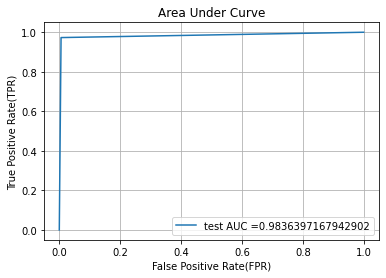

the maximum value of tpr*(1-fpr) 0.9674354282648124 for threshold 1
Test confusion matrix


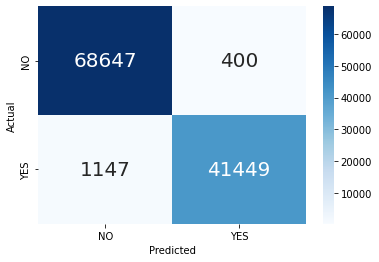

In [ ]:
rf, meta_model_rf,column_rf = custom_model(49,5)

In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_rf.pkl", 'wb') as file:
    pickle.dump(rf, file)

# 8.1.6. Custom Models with K Samples as LGBM

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished


The Best parameters are:  {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}
The Recall score of Test:  0.9812893229411213
The F1_Score of Test:  0.9833092205088394


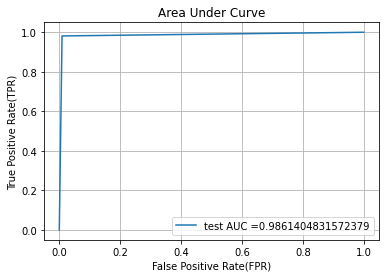

the maximum value of tpr*(1-fpr) 0.972449518766148 for threshold 1
Test confusion matrix


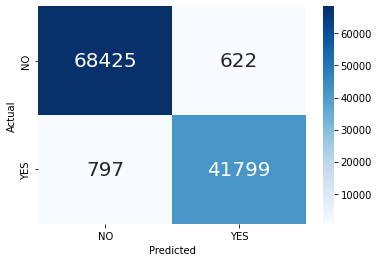

In [ ]:
lgbm, meta_model_lgbm,column_lgbm = custom_model(49,6)

In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_lgbm.pkl", 'wb') as file:
    pickle.dump(lgbm, file)

# 8.2. Test Data on Meta_model

# 8.2.1. Test Data using LogisticRegression as Meta_model

In [ ]:
#This function takes the x and y the data i.e independent variables and dependent variables

def test_predict(train,test_data):
  
  
  meta_mdl = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_lr.pkl", 'rb'))
  samples = 49
  test_pred = []
  for i in range(samples):
    m_dt = meta_model_dt[i].predict(train.iloc[:,column_dt[i]])
    test_pred.append(m_dt)
  test_pred = np.array(test_pred).transpose()
  
  y_test_pred = meta_mdl.predict(test_pred)
    
  test_fpr, test_tpr, te_thresholds = roc_curve(test_data, y_test_pred)

  #recall_score
  recall_score_test = recall_score(test_data,y_test_pred)

  #f1_score
  f1_score_test = f1_score(test_data,y_test_pred)

  print("="*50)
  print("The Recall score of Test: ",recall_score_test)
  print("="*50)
  print("The F1_Score of Test: ",f1_score_test)
  print("="*50)
  
  plt.figure(1)
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")
  plt.title("Area Under Curve")
  plt.grid()
  plt.show()
  
  # confusion matrix
  plt.figure(2)
  best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
  print("Test confusion matrix") 
  confusion_matrix_test = confusion_matrix(test_data, predict_with_best_t(y_test_pred, best_t))
  y_true = ['NO','YES']
  y_pred = ['NO','YES']
  df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
  df_confusion_matrix_test.index.name = 'Actual'
  df_confusion_matrix_test.columns.name = 'Predicted'
  sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')
  plt.show()

  return y_test_pred

The Recall score of Test:  0.8618884402291295
The F1_Score of Test:  0.8940543304881463


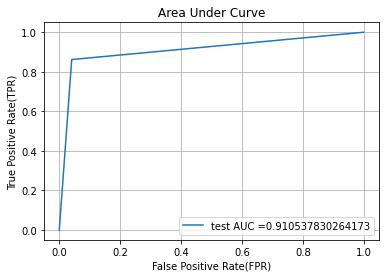

the maximum value of tpr*(1-fpr) 0.826712377191406 for threshold 1
Test confusion matrix


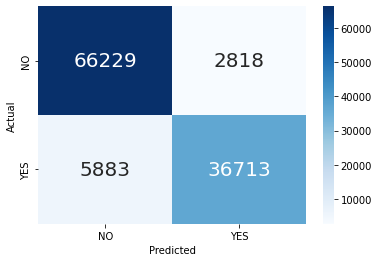

The Prediction of Test Data on Best Meta_Model:
 [0 0 0 ... 1 0 0]


In [ ]:
train = X_test
test_data = y_test
Prediction_of_test_data = test_predict(train,test_data)

print("The Prediction of Test Data on Best Meta_Model:\n",Prediction_of_test_data) 

# 8.2.2. Test Data using SGDClassifier as Meta_model

In [ ]:
#This function takes the x and y the data i.e independent variables and dependent variables

def test_predict(train,test_data):
    
  meta_mdl = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_sgd.pkl", 'rb'))
  samples = 49
  test_pred = []
  for i in range(samples):
    m_dt = meta_model_dt[i].predict(train.iloc[:,column_dt[i]])
    test_pred.append(m_dt)
  test_pred = np.array(test_pred).transpose()
  
  y_test_pred = meta_mdl.predict(test_pred)
    
  test_fpr, test_tpr, te_thresholds = roc_curve(test_data, y_test_pred)

  #recall_score
  recall_score_test = recall_score(test_data,y_test_pred)

  #f1_score
  f1_score_test = f1_score(test_data,y_test_pred)

  print("="*50)
  print("The Recall score of Test: ",recall_score_test)
  print("="*50)
  print("The F1_Score of Test: ",f1_score_test)
  print("="*50)
  
  plt.figure(1)
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")
  plt.title("Area Under Curve")
  plt.grid()
  plt.show()
  
  # confusion matrix
  plt.figure(2)
  best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
  print("Test confusion matrix") 
  confusion_matrix_test = confusion_matrix(test_data, predict_with_best_t(y_test_pred, best_t))
  y_true = ['NO','YES']
  y_pred = ['NO','YES']
  df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
  df_confusion_matrix_test.index.name = 'Actual'
  df_confusion_matrix_test.columns.name = 'Predicted'
  sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')
  plt.show()

  return y_test_pred

The Recall score of Test:  0.9602779603718659
The F1_Score of Test:  0.9678671146656569


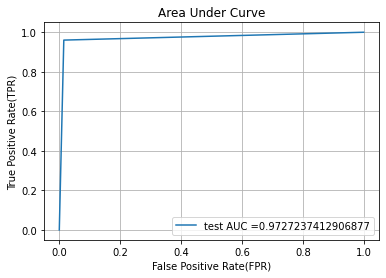

the maximum value of tpr*(1-fpr) 0.9460365794078733 for threshold 1
Test confusion matrix


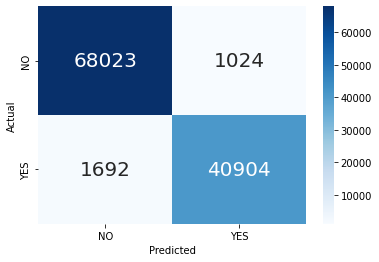

The Prediction of Test Data on Best Meta_Model:
 [0 1 0 ... 1 0 0]


In [ ]:
train = X_test
test_data = y_test
Prediction_of_test_data = test_predict(train,test_data)

print("The Prediction of Test Data on Best Meta_Model:\n",Prediction_of_test_data) 

# 8.2.3. Test Data using DecisionTree as Meta_Model

In [ ]:
#This function takes the x and y the data i.e independent variables and dependent variables

def test_predict(train,test_data):
  
  meta_mdl = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_dt.pkl", 'rb'))
  samples = 49
  test_pred = []
  for i in range(samples):
    m_dt = meta_model_dt[i].predict(train.iloc[:,column_dt[i]])
    test_pred.append(m_dt)
  test_pred = np.array(test_pred).transpose()
  
  y_test_pred = meta_mdl.predict(test_pred)
    
  test_fpr, test_tpr, te_thresholds = roc_curve(test_data, y_test_pred)

  #recall_score
  recall_score_test = recall_score(test_data,y_test_pred)

  #f1_score
  f1_score_test = f1_score(test_data,y_test_pred)

  print("="*50)
  print("The Recall score of Test: ",recall_score_test)
  print("="*50)
  print("The F1_Score of Test: ",f1_score_test)
  print("="*50)
  
  plt.figure(1)
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")
  plt.title("Area Under Curve")
  plt.grid()
  plt.show()
  
  # confusion matrix
  plt.figure(2)
  best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
  print("Test confusion matrix") 
  confusion_matrix_test = confusion_matrix(test_data, predict_with_best_t(y_test_pred, best_t))
  y_true = ['NO','YES']
  y_pred = ['NO','YES']
  df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
  df_confusion_matrix_test.index.name = 'Actual'
  df_confusion_matrix_test.columns.name = 'Predicted'
  sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')
  plt.show()

  return y_test_pred

The Recall score of Test:  0.9775096253169312
The F1_Score of Test:  0.980652150873185


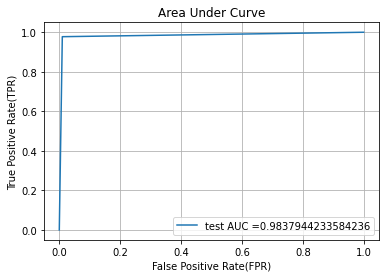

the maximum value of tpr*(1-fpr) 0.9678119687447109 for threshold 1
Test confusion matrix


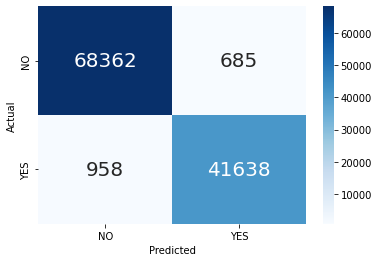

The Prediction of Test Data on Best Meta_Model:
 [0 1 0 ... 1 0 0]


In [ ]:
train = X_test
test_data = y_test
Prediction_of_test_data = test_predict(train,test_data)

print("The Prediction of Test Data on Best Meta_Model:\n",Prediction_of_test_data) 

# 8.2.4. Test Data using Xgboost as Meta_Model

In [ ]:
#This function takes the x and y the data i.e independent variables and dependent variables

def test_predict(train,test_data):
  
  
  meta_mdl = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_xgb.pkl", 'rb'))
  samples = 49
  test_pred = []
  for i in range(samples):
    m_dt = meta_model_dt[i].predict(train.iloc[:,column_dt[i]])
    test_pred.append(m_dt)
  test_pred = np.array(test_pred).transpose()
  
  y_test_pred = meta_mdl.predict(test_pred)
    
  test_fpr, test_tpr, te_thresholds = roc_curve(test_data, y_test_pred)

  #recall_score
  recall_score_test = recall_score(test_data,y_test_pred)

  #f1_score
  f1_score_test = f1_score(test_data,y_test_pred)

  print("="*50)
  print("The Recall score of Test: ",recall_score_test)
  print("="*50)
  print("The F1_Score of Test: ",f1_score_test)
  print("="*50)
  
  plt.figure(1)
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")
  plt.title("Area Under Curve")
  plt.grid()
  plt.show()
  
  # confusion matrix
  plt.figure(2)
  best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
  print("Test confusion matrix") 
  confusion_matrix_test = confusion_matrix(test_data, predict_with_best_t(y_test_pred, best_t))
  y_true = ['NO','YES']
  y_pred = ['NO','YES']
  df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
  df_confusion_matrix_test.index.name = 'Actual'
  df_confusion_matrix_test.columns.name = 'Predicted'
  sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')
  plt.show()

  return y_test_pred

The Recall score of Test:  0.9443844492440605
The F1_Score of Test:  0.9668557419602943


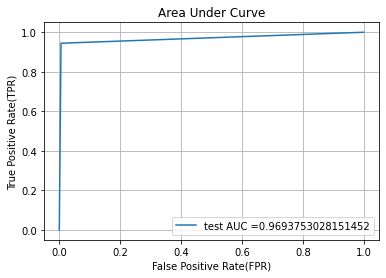

the maximum value of tpr*(1-fpr) 0.9390639349457429 for threshold 1
Test confusion matrix


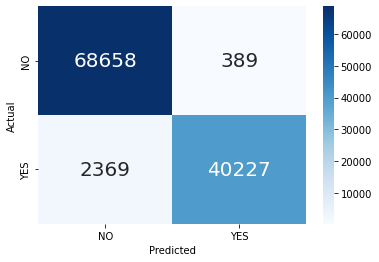

The Prediction of Test Data on Best Meta_Model:
 [0 1 0 ... 1 0 0]


In [ ]:
train = X_test
test_data = y_test
Prediction_of_test_data = test_predict(train,test_data)

print("The Prediction of Test Data on Best Meta_Model:\n",Prediction_of_test_data) 

# 8.2.5. Test Data using RandomForest as Meta_Model

In [ ]:
#This function takes the x and y the data i.e independent variables and dependent variables

def test_predict(train,test_data):
    
  meta_mdl = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_rf.pkl", 'rb'))
  samples = 49
  test_pred = []
  for i in range(samples):
    m_dt = meta_model_dt[i].predict(train.iloc[:,column_dt[i]])
    test_pred.append(m_dt)
  test_pred = np.array(test_pred).transpose()
  
  y_test_pred = meta_mdl.predict(test_pred)
    
  test_fpr, test_tpr, te_thresholds = roc_curve(test_data, y_test_pred)

  #recall_score
  recall_score_test = recall_score(test_data,y_test_pred)

  #f1_score
  f1_score_test = f1_score(test_data,y_test_pred)

  print("="*50)
  print("The Recall score of Test: ",recall_score_test)
  print("="*50)
  print("The F1_Score of Test: ",f1_score_test)
  print("="*50)
  
  plt.figure(1)
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")
  plt.title("Area Under Curve")
  plt.grid()
  plt.show()
  
  # confusion matrix
  plt.figure(2)
  best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
  print("Test confusion matrix") 
  confusion_matrix_test = confusion_matrix(test_data, predict_with_best_t(y_test_pred, best_t))
  y_true = ['NO','YES']
  y_pred = ['NO','YES']
  df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
  df_confusion_matrix_test.index.name = 'Actual'
  df_confusion_matrix_test.columns.name = 'Predicted'
  sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')
  plt.show()

  return y_test_pred

The Recall score of Test:  0.9449478824302752
The F1_Score of Test:  0.9654949087899831


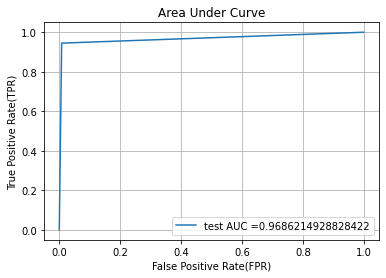

the maximum value of tpr*(1-fpr) 0.937667156642726 for threshold 1
Test confusion matrix


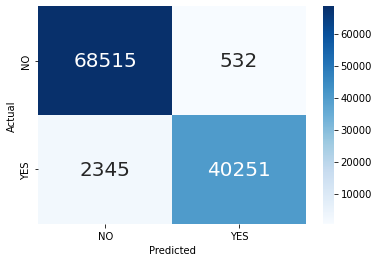

The Prediction of Test Data on Best Meta_Model:
 [0 1 0 ... 1 0 0]


In [ ]:
train = X_test
test_data = y_test
Prediction_of_test_data = test_predict(train,test_data)

print("The Prediction of Test Data on Best Meta_Model:\n",Prediction_of_test_data) 

# 8.2.6. Test Data using LGBM as Meta_Model

In [ ]:
#This function takes the x and y the data i.e independent variables and dependent variables

def test_predict(train,test_data):
  
  
  meta_mdl = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/meta_model_lgbm.pkl", 'rb'))
  samples = 49
  test_pred = []
  for i in range(samples):
    m_dt = meta_model_dt[i].predict(train.iloc[:,column_dt[i]])
    test_pred.append(m_dt)
  test_pred = np.array(test_pred).transpose()
  
  y_test_pred = meta_mdl.predict(test_pred)
    
  test_fpr, test_tpr, te_thresholds = roc_curve(test_data, y_test_pred)

  #recall_score
  recall_score_test = recall_score(test_data,y_test_pred)

  #f1_score
  f1_score_test = f1_score(test_data,y_test_pred)

  print("="*50)
  print("The Recall score of Test: ",recall_score_test)
  print("="*50)
  print("The F1_Score of Test: ",f1_score_test)
  print("="*50)
  
  plt.figure(1)
  plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")
  plt.title("Area Under Curve")
  plt.grid()
  plt.show()
  
  # confusion matrix
  plt.figure(2)
  best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
  print("Test confusion matrix") 
  confusion_matrix_test = confusion_matrix(test_data, predict_with_best_t(y_test_pred, best_t))
  y_true = ['NO','YES']
  y_pred = ['NO','YES']
  df_confusion_matrix_test = pd.DataFrame(confusion_matrix_test, columns=np.unique(y_true), index = np.unique(y_true))
  df_confusion_matrix_test.index.name = 'Actual'
  df_confusion_matrix_test.columns.name = 'Predicted'
  sns.heatmap(df_confusion_matrix_test, annot=True,annot_kws={"size": 20},fmt="d",cmap='Blues')
  plt.show()

  return y_test_pred

The Recall score of Test:  0.9604188186684196
The F1_Score of Test:  0.9701669512426485


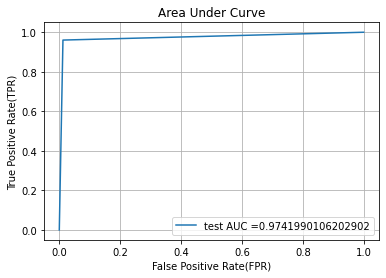

the maximum value of tpr*(1-fpr) 0.9488738186033221 for threshold 1
Test confusion matrix


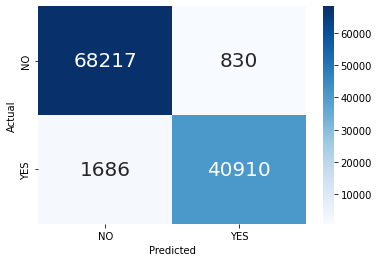

The Prediction of Test Data on Best Meta_Model:
 [0 1 0 ... 1 0 0]


In [ ]:
train = X_test
test_data = y_test
Prediction_of_test_data = test_predict(train,test_data)

print("The Prediction of Test Data on Best Meta_Model:\n",Prediction_of_test_data) 

# 8.3. Meta_model Results

In [ ]:
print("Custom Models Results of d2_test")

x = PrettyTable()
x.field_names = ["Model","d2_Test_Recall","d2_Test_F1_Score","d2_Test_AUC"]

x.add_row(["meta_model_LogisticRegression",0.97,0.98,0.98])
x.add_row(["meta_model_SGDClassifier",0.97,0.97,0.98])
x.add_row(["meta_model_DecisionTreeClassifier", 0.97,0.98,0.98])
x.add_row(["meta_model_XGBClassifier",0.97,0.98,0.98])
x.add_row(["meta_model_RandomForestClassifier",0.97,0.98,0.98])
x.add_row(["meta_model_LGBMClassifier",0.98,0.98,0.98])
print(x)
print("="*100)

Custom Models Results of d2_test
Consider DATASET AS BALANCED DATA
+-----------------------------------+----------------+------------------+-------------+
|               Model               | d2_Test_Recall | d2_Test_F1_Score | d2_Test_AUC |
+-----------------------------------+----------------+------------------+-------------+
|   meta_model_LogisticRegression   |      0.97      |       0.98       |     0.98    |
|      meta_model_SGDClassifier     |      0.97      |       0.97       |     0.98    |
| meta_model_DecisionTreeClassifier |      0.97      |       0.98       |     0.98    |
|      meta_model_XGBClassifier     |      0.97      |       0.98       |     0.98    |
| meta_model_RandomForestClassifier |      0.97      |       0.98       |     0.98    |
|     meta_model_LGBMClassifier     |      0.98      |       0.98       |     0.98    |
+-----------------------------------+----------------+------------------+-------------+


In [ ]:
print("Meta_Models Results of X_Test_20%")

x = PrettyTable()
x.field_names = ["Model","X_test_20%_Recall","X_test_20%_F1_Score","X_test_20%_AUC"]

x.add_row(["meta_model_20%_LogisticRegression",0.86,0.89,0.91])
x.add_row(["meta_model_20%_SGDClassifier",0.96,0.96,0.97])
x.add_row(["meta_model_20%_DecisionTreeClassifier", 0.97,0.98,0.98])
x.add_row(["meta_model_20%_XGBClassifier",0.94,0.96,0.96])
x.add_row(["meta_model_20%_RandomForestClassifier",0.94,0.96,0.96])
x.add_row(["meta_model_20%_LGBMClassifier",0.96,0.97,0.97])
print(x) 
print("="*100) 

Meta_Models Results of X_Test_20%
+---------------------------------------+-------------------+---------------------+----------------+
|                 Model                 | X_test_20%_Recall | X_test_20%_F1_Score | X_test_20%_AUC |
+---------------------------------------+-------------------+---------------------+----------------+
|   meta_model_20%_LogisticRegression   |        0.86       |         0.89        |      0.91      |
|      meta_model_20%_SGDClassifier     |        0.96       |         0.96        |      0.97      |
| meta_model_20%_DecisionTreeClassifier |        0.97       |         0.98        |      0.98      |
|      meta_model_20%_XGBClassifier     |        0.94       |         0.96        |      0.96      |
| meta_model_20%_RandomForestClassifier |        0.94       |         0.96        |      0.96      |
|     meta_model_20%_LGBMClassifier     |        0.96       |         0.97        |      0.97      |
+---------------------------------------+----------------